## Cluster methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

sns.set_theme(
    style="whitegrid",
    font_scale=1,
    rc={
        "figure.dpi": 150,
        "savefig.dpi": 300
    }
)
tol_colors = [ "#0072B2", "#E69F00", "#009E73", "#F0E442", "#D55E00", "#CC79A7", "#999999",  "#56B4E9"]
sns.set_palette(tol_colors)

plt.rcParams.update({
    "font.size": 12,          # default font size for all text
    "axes.titlesize": 12,     # subplot titles
    "axes.labelsize": 12,     # x and y labels
    "xtick.labelsize": 12,    # tick labels
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "figure.titlesize": 14,    # fig.suptitle()
    "xtick.bottom": True,   # show ticks on x-axis bottom
    "xtick.top": False,     # hide ticks on x-axis top
    "ytick.left": True,     # show ticks on y-axis left
    "ytick.right": False,   # hide ticks on y-axis right
    "xtick.direction": "out",
    "ytick.direction": "out"

})

results_df = pd.read_csv("results/big_dataset/untargeted/cam_comparison_metrics_combined.csv")
metric_columns = [
    'mean pixel difference', 'percentage of different pixels',
    'cosine similarity', 'activation ratio', 'JS divergence',
    'important activation ratio', 'intersection over union', 'SSIM',
    'Spearman\'s rank coefficient', 'number of regions difference']

selected_metrics = ["percentage of different pixels", "cosine similarity", "activation ratio", "important activation ratio", "number of regions difference", "intersection over union"]

In [2]:
results_df["percentage of different pixels"] = results_df["percentage of different pixels"] / 100.0    # Normalize percentage of different pixels

single_attack_df = results_df[results_df["attack"] == "Fast Gradient Sign Method (FGSM)"]

In [3]:
print("Creating method profiles...")
method_profiles = results_df.groupby('method')[metric_columns].mean()

# Create richer profiles using multiple aggregations
method_profiles = results_df.groupby('method')[metric_columns].agg(['mean', 'std', 'median'])

# This creates multi-level columns (e.g., 'cosine similarity_mean', 'cosine similarity_std')
# We can flatten them for easier use with scikit-learn
method_profiles.columns = ['_'.join(col).strip() for col in method_profiles.columns.values]

print(f"Number of unique methods: {len(method_profiles)}")
print(f"Method profiles shape: {method_profiles.shape}")

Creating method profiles...
Number of unique methods: 9
Method profiles shape: (9, 30)


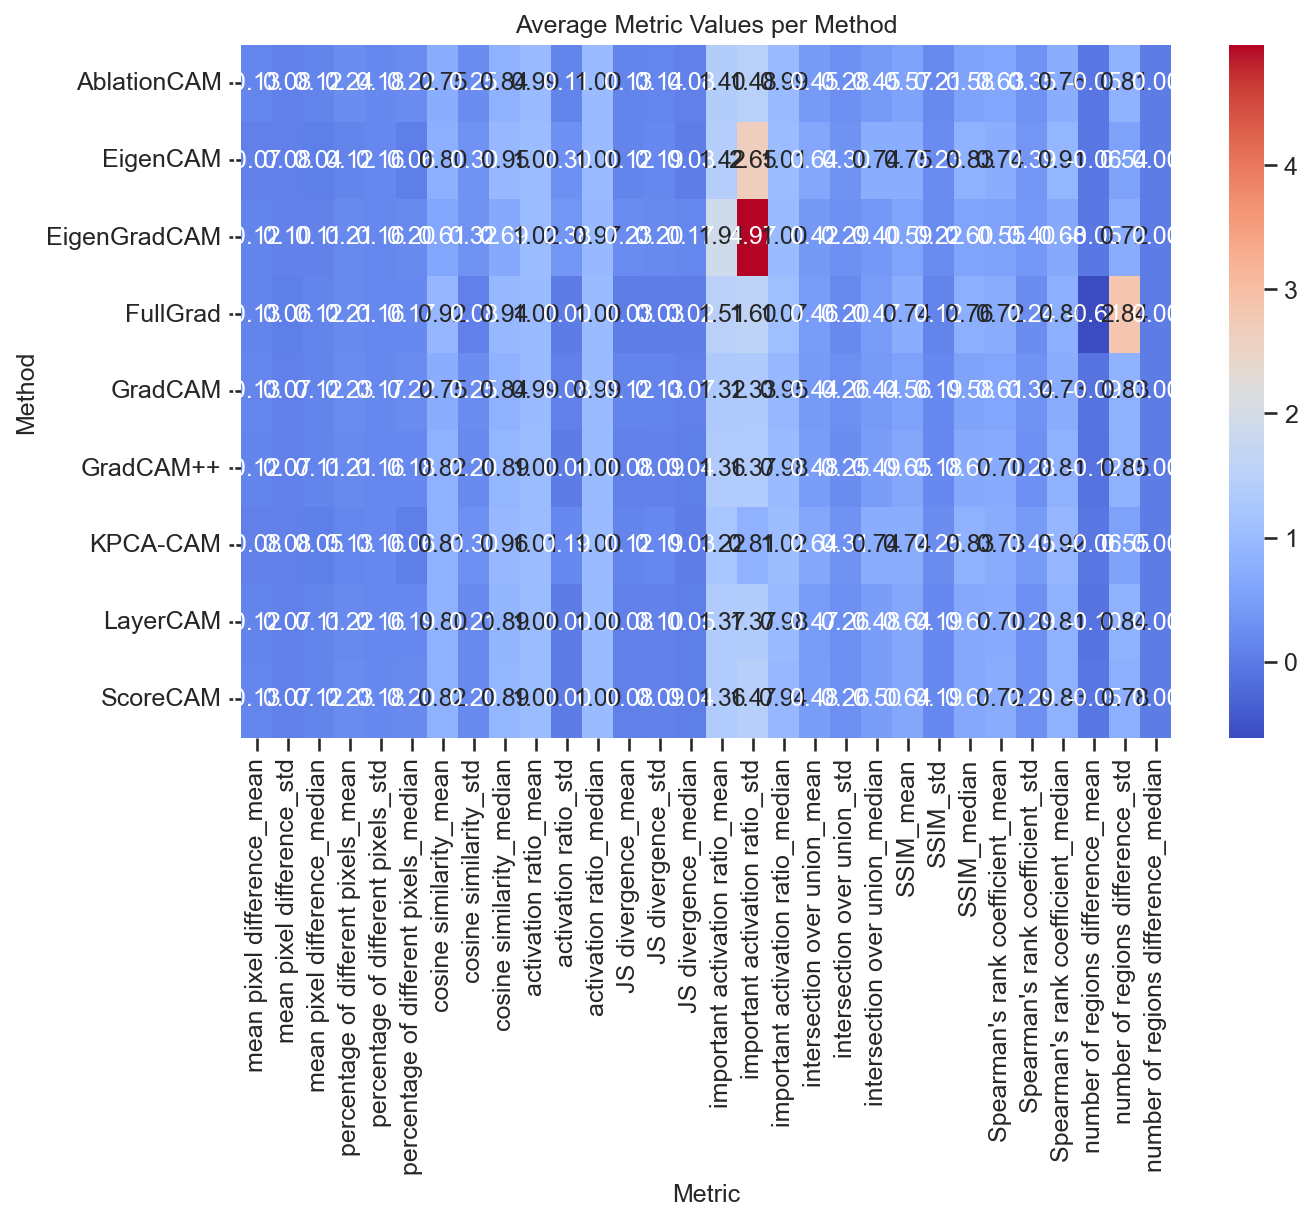

In [4]:
plt.figure(figsize=(10, 6))
sns.heatmap(method_profiles, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Average Metric Values per Method")
plt.ylabel("Method")
plt.xlabel("Metric")
plt.show()

In [5]:
# Step 2: Standardize the data for clustering
print("\nStandardizing the data...")
scaler = StandardScaler()
method_profiles_scaled = scaler.fit_transform(method_profiles)
method_profiles_scaled_df = pd.DataFrame(method_profiles_scaled, 
                                        index=method_profiles.index, 
                                        columns=method_profiles.columns)
method_profiles_scaled_df


Standardizing the data...


mean pixel difference_mean  mean pixel difference_std  \
method                                                                
AblationCAM                     0.833442                   0.292289   
EigenCAM                       -1.958826                   0.363937   
EigenGradCAM                    0.210627                   2.119274   
FullGrad                        0.482431                  -1.811402   
GradCAM                         0.776096                  -0.214912   
GradCAM++                       0.301274                  -0.698914   
KPCA-CAM                       -1.700861                   0.522985   
LayerCAM                        0.373183                  -0.422875   
ScoreCAM                        0.682633                  -0.150382   

              mean pixel difference_median  \
method                                       
AblationCAM                       0.767587   
EigenCAM                         -1.898371   
EigenGradCAM                      0.192845   
FullGrad                          0.538890   
GradCAM                           0.751212   
GradCAM++                         0.372289   
KPCA-CAM                         -1.787547   
LayerCAM                          0.441895   
ScoreCAM                          0.621200   

              percentage of different pixels_mean  \
method                                              
AblationCAM                              0.998585   
EigenCAM                                -1.884906   
EigenGradCAM                             0.286391   
FullGrad                                 0.164224   
GradCAM                                  0.857581   
GradCAM++                                0.199688   
KPCA-CAM                                -1.708875   
LayerCAM                                 0.378926   
ScoreCAM                                 0.708385   

              percentage of different pixels_std  \
method                                             
AblationCAM                             1.826324   
EigenCAM                               -1.239030   
EigenGradCAM                           -0.748641   
FullGrad                               -0.640239   
GradCAM                                 0.189425   
GradCAM++                              -0.651080   
KPCA-CAM                               -0.339869   
LayerCAM                               -0.004266   
ScoreCAM                                1.607377   

              percentage of different pixels_median  cosine similarity_mean  \
method                                                                        
AblationCAM                                0.924869               -0.470280   
EigenCAM                                  -1.832563                0.121438   
EigenGradCAM                               0.550146               -2.272793   
FullGrad                                   0.088997                1.702107   
GradCAM                                    0.814311               -0.452954   
GradCAM++                                  0.239670                0.401628   
KPCA-CAM                                  -1.796688                0.301887   
LayerCAM                                   0.416758                0.234561   
ScoreCAM                                   0.594499                0.434406   

              cosine similarity_std  cosine similarity_median  \
method                                                          
AblationCAM                0.257572                 -0.437625   
EigenCAM                   0.995832                  0.927926   
EigenGradCAM               1.229160                 -2.428097   
FullGrad                  -2.214937                  0.843649   
GradCAM                    0.156815                 -0.444568   
GradCAM++                 -0.469719                  0.211463   
KPCA-CAM                   0.926187                  1.022652   
LayerCAM                  -0.309791                  0.099999   
ScoreCAM                  -0.571118             

<Axes: >

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


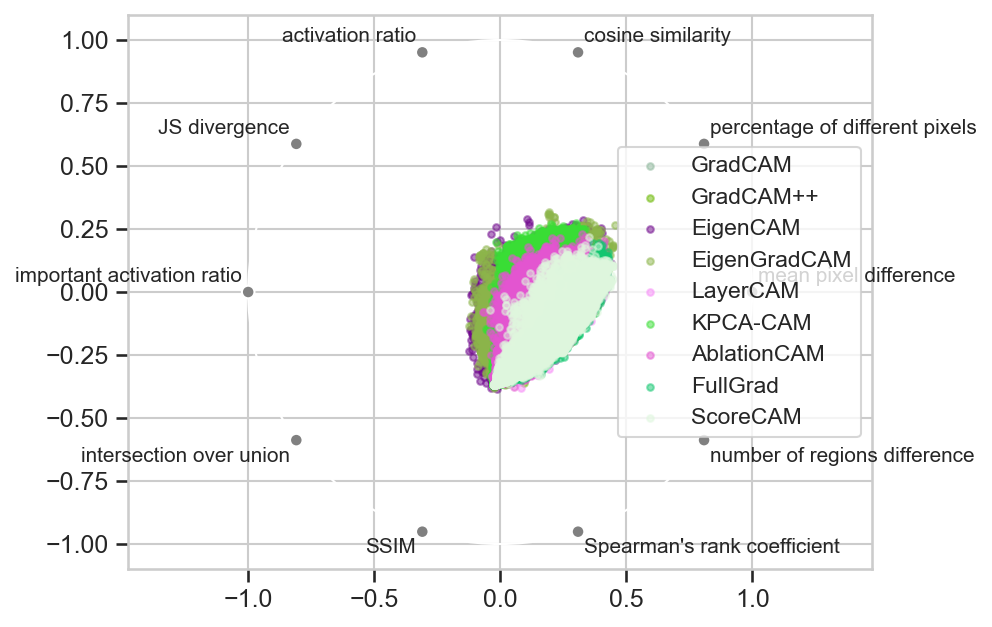

In [6]:
# visualize radviz with reduced point size
pd.plotting.radviz(results_df[metric_columns + ['method']], 'method', alpha=0.5, s=10)

In [36]:
reduced_data = results_df.sample(10000, random_state=33)

In [32]:
results_df.columns

Index(['image ID', 'method', 'attack', 'true class', 'predicted class',
       'images mean difference', 'original score', 'adversarial score',
       'mean pixel difference', 'percentage of different pixels',
       'number of regions original', 'number of regions adversarial',
       'cosine similarity', 'activation ratio', 'JS divergence',
       'important activation ratio', 'intersection over union', 'SSIM',
       'Spearman's rank coefficient', 'number of regions difference'],
      dtype='object')

In [ ]:
## add method as categorical float to dataframe
results_df['method_float'] = results_df['method'].astype('category').cat.codes.astype(float)

In [ ]:
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

methods = results_df['method'].unique()
attacks = results_df['attack'].unique()
# check distance correlation for each method, attack
for method in methods:
    for attack in attacks:
        subset = results_df[(results_df['method'] == method) & (results_df['attack'] == attack)]
        if not subset.empty and len(subset) > 5:  # Need enough samples for meaningful correlation
            # Calculate distance correlation for each metric
            images_mean_diff = subset['images mean difference'].values
            
            for metric in metric_columns:
                metric_values = subset[metric].values
                
                # Calculate Pearson correlation as a simple distance measure
                if len(np.unique(images_mean_diff)) > 1 and len(np.unique(metric_values)) > 1:
                    corr_coef, p_value = pearsonr(images_mean_diff, metric_values)
                    
                    # Print if correlation is significant (|r| > 0.5 and p < 0.05)
                    if abs(corr_coef) > 0.5 and p_value < 0.05:
                        print(f"Method: {method}, Attack: {attack}")
                        print(f"  {metric}: r={corr_coef:.3f}, p={p_value:.3f}")

Method: FullGrad, Attack: Fast Gradient Sign Method (FGSM)
  SSIM: r=-0.550, p=0.000
Method: FullGrad, Attack: L2 Clipping Aware Repeated Additive Gaussian Noise
  SSIM: r=-0.520, p=0.000
Method: FullGrad, Attack: L2 Clipping Aware Repeated Additive Uniform Noise
  SSIM: r=-0.511, p=0.000
Method: FullGrad, Attack: L2 Repeated Additive Gaussian Noise
  SSIM: r=-0.517, p=0.000
Method: FullGrad, Attack: L2 Repeated Additive Uniform Noise
  SSIM: r=-0.528, p=0.000
Method: FullGrad, Attack: Linear Search Blended Uniform Noise
  SSIM: r=-0.559, p=0.000
Method: FullGrad, Attack: Linf Additive Uniform Noise
  SSIM: r=-0.524, p=0.000
Method: FullGrad, Attack: Linf Repeated Additive Uniform Noise
  SSIM: r=-0.559, p=0.000


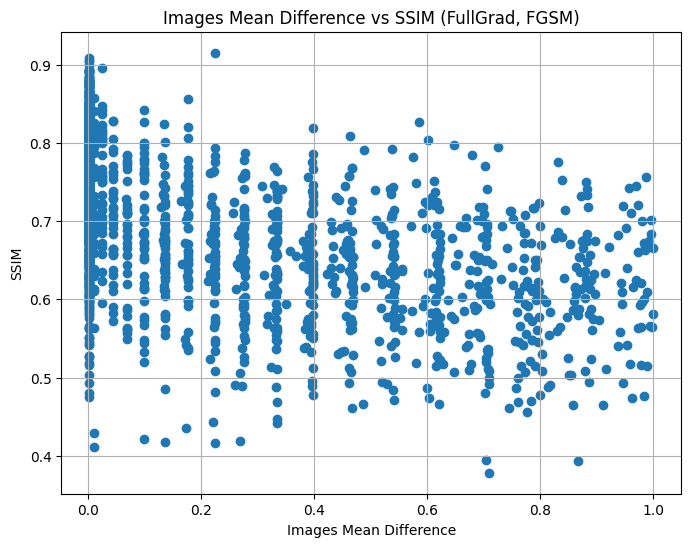

In [38]:
# plot images mean difference against SSIM for attack Fast Gradient Sign Method (FGSM) and method FullGrad

plt.figure(figsize=(8, 6))

selected_data = results_df[(results_df['method'] == 'FullGrad') & (results_df['attack'] == 'Fast Gradient Sign Method (FGSM)')]

plt.scatter(selected_data['images mean difference'], selected_data['SSIM'])
plt.xlabel('Images Mean Difference')
plt.ylabel('SSIM')
plt.title('Images Mean Difference vs SSIM (FullGrad, FGSM)')
plt.grid()
plt.show()

In [69]:
noise_based_attacks = [name for name in results_df["attack"].unique() if "Noise" in name]

noise_based_attacks

['L2 Repeated Additive Uniform Noise',
 'L2 Repeated Additive Gaussian Noise',
 'Linear Search Blended Uniform Noise',
 'Salt And Pepper Noise',
 'L2 Clipping Aware Additive Uniform Noise',
 'Linf Repeated Additive Uniform Noise',
 'L2 Clipping Aware Repeated Additive Uniform Noise',
 'L2 Clipping Aware Repeated Additive Gaussian Noise',
 'L2 Clipping Aware Additive Gaussian Noise',
 'L2 Additive Uniform Noise',
 'L2 Additive Gaussian Noise',
 'Linf Additive Uniform Noise']

In [73]:
noise_df = results_df[results_df['attack'].isin(noise_based_attacks)]
metric = 'cosine similarity'  # or any other metric
pivot_df = noise_df.pivot_table(
    index=['image ID', 'method'],  # group by these
    columns='attack',              # one column per attack
    values=metric
).reset_index()
corr_matrix = pivot_df[noise_based_attacks].corr()

pivot_df


attack  image ID           method  L2 Additive Gaussian Noise  \
0              0      AblationCAM                    0.925111   
1              0         EigenCAM                    0.884893   
2              0     EigenGradCAM                    0.837896   
3              0         FullGrad                    0.932646   
4              0          GradCAM                    0.918663   
...          ...              ...                         ...   
21928       2999          GradCAM                         NaN   
21929       2999  GradCAMPlusPlus                         NaN   
21930       2999         KPCA_CAM                         NaN   
21931       2999         LayerCAM                         NaN   
21932       2999         ScoreCAM                         NaN   

attack  L2 Additive Uniform Noise  L2 Clipping Aware Additive Gaussian Noise  \
0                        0.910053                                   0.918960   
1                        0.876834                                   0.887144   
2                        0.806717                                   0.838607   
3                        0.914089                                   0.875937   
4                        0.906518                                   0.910434   
...                           ...                                        ...   
21928                         NaN                                        NaN   
21929                         NaN                                        NaN   
21930                         NaN                                        NaN   
21931                         NaN                                        NaN   
21932                         NaN                                        NaN   

attack  L2 Clipping Aware Additive Uniform Noise  \
0                                       0.930820   
1                                       0.888148   
2                                       0.863084   
3                                       0.913782   
4                                       0.916986   
...                                          ...   
21928                                        NaN   
21929                                        NaN   
21930                                        NaN   
21931                                        NaN   
21932                                        NaN   

attack  L2 Clipping Aware Repeated Additive Gaussian Noise  \
0                                                0.908633    
1                                                0.888823    
2                                                0.816355    
3                                                0.927133    
4                                                0.906825    
...                                                   ...    
21928                                            0.574189    
21929                                            0.718399    
21930                                            0.126628    
21931                                            0.703733    
21932                                            0.629960    

attack  L2 Clipping Aware Repeated Additive Uniform Noise  \
0                                                0.901721   
1                                                0.855277   
2                                                0.811486   
3                                                0.867636   
4                                                0.894783   
...                                                   ...   
21928                                            0.497003   
21929                                            0.663609   
21930                                            0.137689   
21931                                            0.673807   
21932                                            0.786065   

attack  L2 Repeated Additive Gaussian Noise  \
0                                  0.932129   
1                                  0.894543   
2             

In [79]:
pivoted = results_df.pivot_table(
    index=['image ID', 'method'],
    columns='attack',
    values=metric_columns
)
pivoted

JS divergence                        \
attack                   Boundary Attack DDN Attack EAD Attack   
image ID method                                                  
0        AblationCAM            0.047068   0.475200   0.291772   
         EigenCAM               0.024613   0.525252   0.638689   
         EigenGradCAM           0.127237   0.598186   0.485516   
         FullGrad               0.027738   0.021114   0.021122   
         GradCAM                0.039198   0.418142   0.255323   
...                                  ...        ...        ...   
2999     GradCAM                0.119971   0.214843   0.129983   
         GradCAMPlusPlus        0.065464   0.083724   0.060581   
         KPCA_CAM               0.077122   0.351568   0.068678   
         LayerCAM               0.063943   0.118483   0.070218   
         ScoreCAM               0.082546   0.027335   0.070059   

                                                     \
attack                   Fast Gradient Method (FGM)   
image ID method                                       
0        AblationCAM                            NaN   
         EigenCAM                               NaN   
         EigenGradCAM                           NaN   
         FullGrad                               NaN   
         GradCAM                                NaN   
...                                             ...   
2999     GradCAM                           0.165877   
         GradCAMPlusPlus                   0.083576   
         KPCA_CAM                          0.564709   
         LayerCAM                          0.095107   
         ScoreCAM                          0.060916   

                                                                        \
attack                   Fast Gradient Sign Method (FGSM) GaussianBlur   
image ID method                                                          
0        AblationCAM                             0.031179     0.108605   
         EigenCAM                                0.048553     0.111038   
         EigenGradCAM                            0.084114     0.159257   
         FullGrad                                0.025817     0.033801   
         GradCAM                                 0.034862     0.112411   
...                                                   ...          ...   
2999     GradCAM                                 0.162976     0.137610   
         GradCAMPlusPlus                         0.084437     0.083873   
         KPCA_CAM                                0.512826     0.540898   
         LayerCAM                                0.089708     0.096041   
         ScoreCAM                                0.120341     0.075444   

                                                      \
attack                   L1 Brendel Bethge    L1 FMN   
image ID method                                        
0        AblationCAM              0.261931  0.281966   
         EigenCAM                 0.564887  0.631197   
         EigenGradCAM             0.417441  0.454415   
         FullGrad                 0.016829  0.021927   
         GradCAM                  0.228839  0.247669   
...                                    ...       ...   
2999     GradCAM                  0.140970  0.210953   
         GradCAMPlusPlus          0.068580  0.130731   
         KPCA_CAM                 0.105186  0.035143   
         LayerCAM                 0.077271  0.146458   
         ScoreCAM                 0.107390  0.130718   

                                                                               \
attack                   L2 Additive Gaussian Noise L2 Additive Uniform Noise   
image ID method                                                                 
0        AblationCAM                       0.032843                  0.038450   
         EigenCAM                          0.048190                  0.047838   
         EigenGradCAM                      0.077472                  0.086140   
         FullGrad      

# train classifier to predict method based on metrics

In [12]:
## train classifier to predict method based on metrics

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [13]:
def run_rf_classification(df, target_col, title, selected_metrics, save_plot=False):

    # Encode attacks to integers
    le_attack = LabelEncoder()
    y = le_attack.fit_transform(df[target_col])

    # Reduce precision of features
    X = df[selected_metrics].astype('float32')

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=76, stratify=y
    )

    # Train RF
    rf = RandomForestClassifier(n_estimators=100, random_state=76, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Predictions
    y_pred = rf.predict(X_test)

    # Metrics
    print(f"\n--- Predicting {target_col} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Feature importance
    importances = pd.Series(rf.feature_importances_, index=selected_metrics).sort_values(ascending=False)
    plt.figure(figsize=(8, 5))
    ax = importances.plot(kind='bar')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title(f"Feature importance for predicting {title}")
    plt.ylabel("Importance")
    plt.tight_layout()
    if save_plot:
        plt.savefig(f"results/feature_importance_{title}.svg")
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", 
                xticklabels=rf.classes_, yticklabels=rf.classes_)
    plt.title(f"Confusion Matrix: Predicting {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


--- Predicting method ---
Accuracy: 0.6322838332920144
              precision    recall  f1-score   support

           0       0.65      0.54      0.59     20168
           1       0.61      0.49      0.55     20169
           2       0.66      0.72      0.69     20168
           3       0.84      0.94      0.89     20169
           4       0.67      0.69      0.68     20168
           5       0.51      0.53      0.52     20168
           6       0.62      0.69      0.65     20168
           7       0.52      0.49      0.50     20168
           8       0.59      0.60      0.59     20169

    accuracy                           0.63    181515
   macro avg       0.63      0.63      0.63    181515
weighted avg       0.63      0.63      0.63    181515



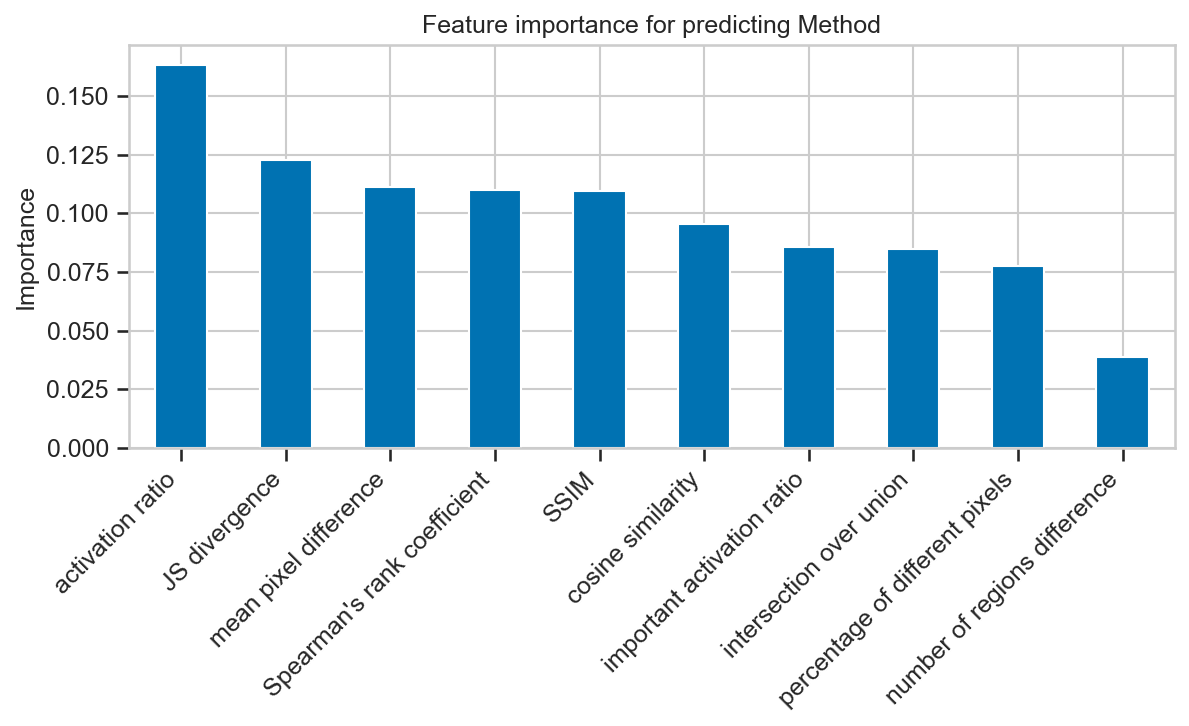

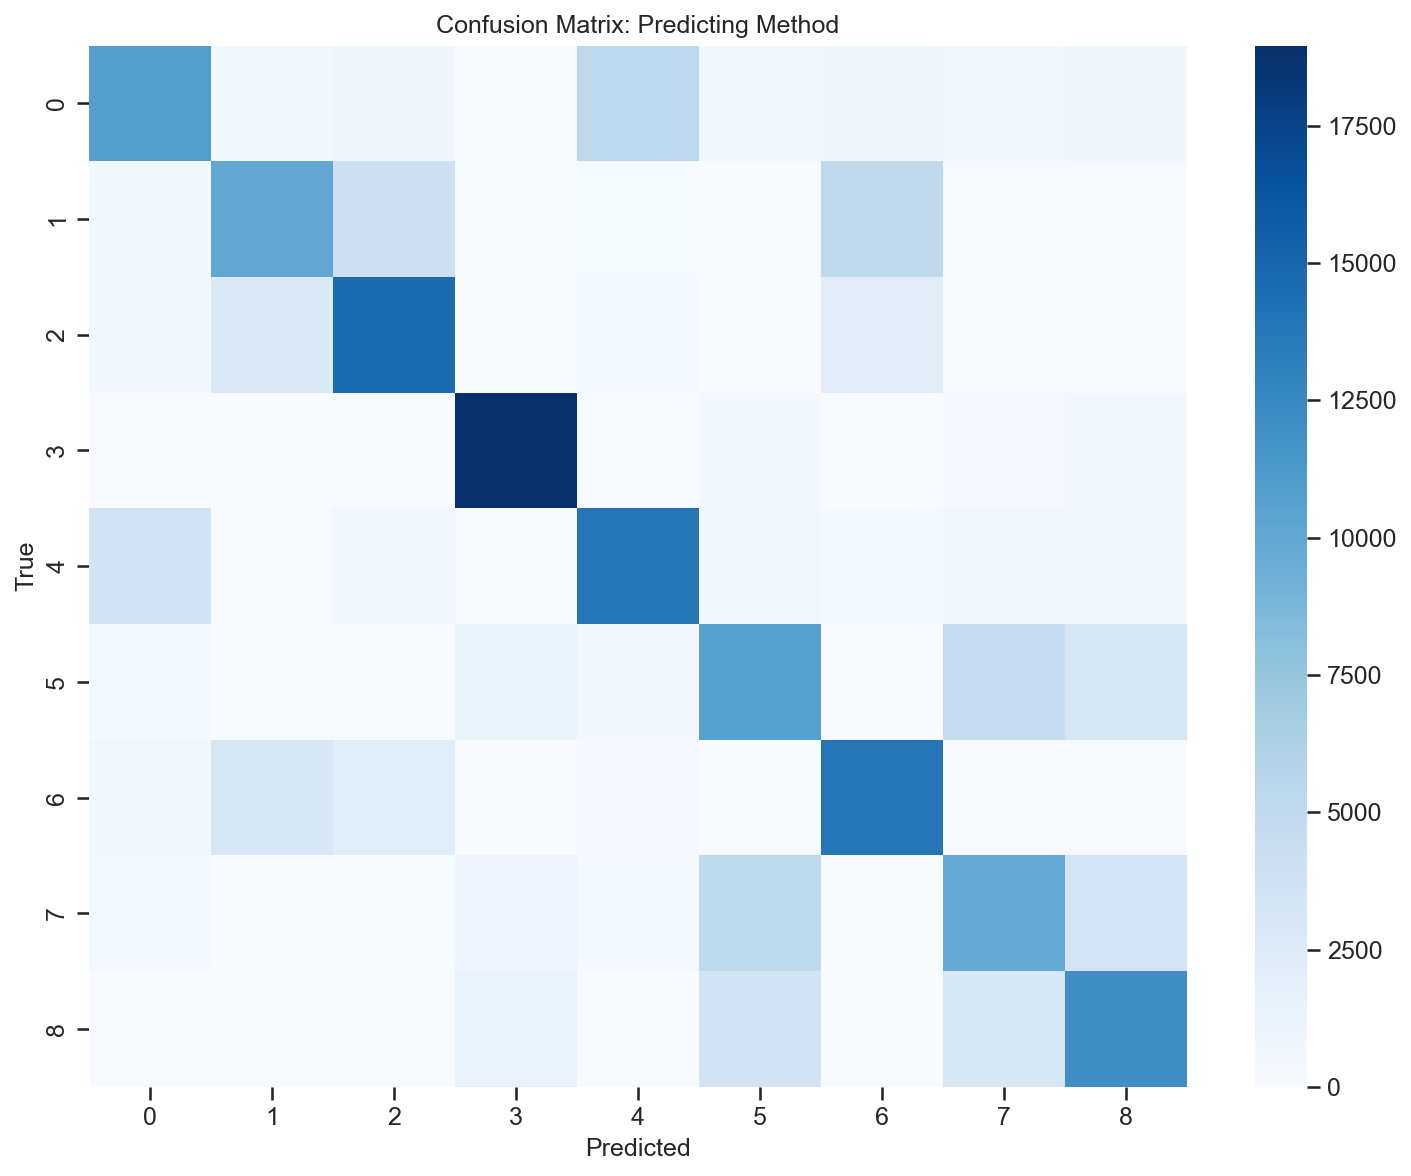

Including class information and score of predicted classes:

--- Predicting method ---
Accuracy: 0.6603586480456161
              precision    recall  f1-score   support

           0       0.68      0.57      0.62     20168
           1       0.64      0.52      0.57     20169
           2       0.69      0.76      0.73     20168
           3       0.86      0.95      0.90     20169
           4       0.69      0.71      0.70     20168
           5       0.53      0.55      0.54     20168
           6       0.64      0.69      0.67     20168
           7       0.54      0.51      0.53     20168
           8       0.66      0.66      0.66     20169

    accuracy                           0.66    181515
   macro avg       0.66      0.66      0.66    181515
weighted avg       0.66      0.66      0.66    181515



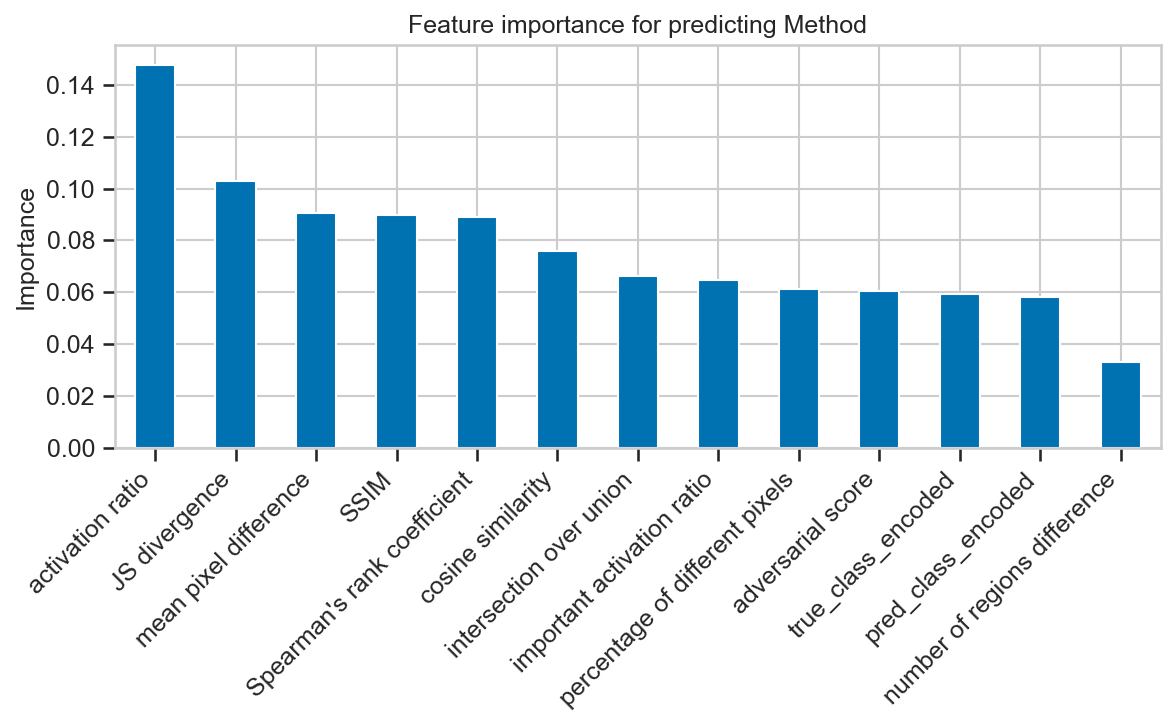

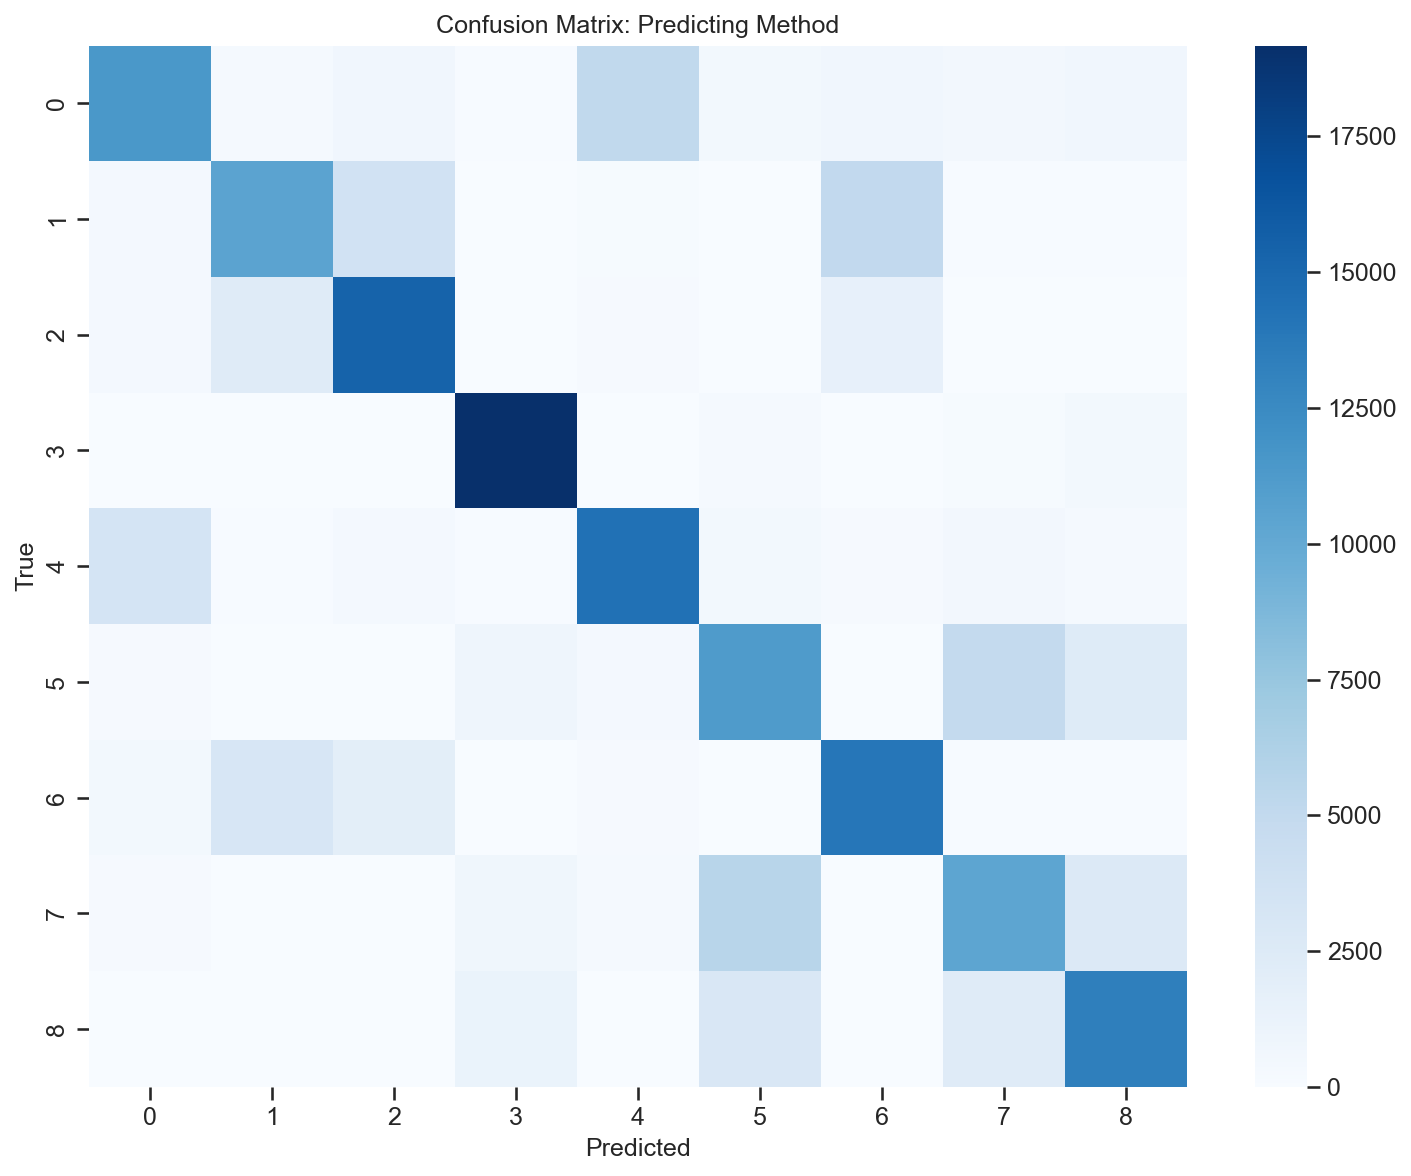

In [8]:
le_true = LabelEncoder()
le_pred = LabelEncoder()

results_df['true_class_encoded'] = le_true.fit_transform(results_df['true class'])
results_df['pred_class_encoded'] = le_pred.fit_transform(results_df['predicted class'])

# --- Run for method ---
run_rf_classification(results_df, "method", "Method", metric_columns)

print("Including class information and score of predicted classes:")

run_rf_classification(results_df, "method", "Method", metric_columns + ["true_class_encoded", "pred_class_encoded", "adversarial score"])

In [121]:
results_df.columns

Index(['image ID', 'method', 'attack', 'true class', 'predicted class',
       'images mean difference', 'original score', 'adversarial score',
       'mean pixel difference', 'percentage of different pixels',
       'number of regions original', 'number of regions adversarial',
       'cosine similarity', 'activation ratio', 'JS divergence',
       'important activation ratio', 'intersection over union', 'SSIM',
       'Spearman's rank coefficient', 'number of regions difference',
       'cluster', 'true_class_encoded', 'pred_class_encoded'],
      dtype='object')

# Distances witin distributions per method for clustering

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, silhouette_samples
from itertools import combinations
from scipy.special import kl_div
from adjustText import adjust_text

class AdversarialAnalysis:
    def __init__(self, results_df):
        """
        Initialize the analysis with your results dataframe
        """
        self.df = results_df
        self.metric_columns = [
            'mean pixel difference', 'activation ratio',  
            'important activation ratio', 'JS divergence',    
            'number of regions difference'
        ]
        self.methods = self.df['method'].unique()
        self.distance_matrices_per_metric = {}
        self.combined_distance_matrices = {}
        self.clustering_results = {}
        self.silhouette_scores = {}
        
    # Add these new methods inside your AdversarialAnalysis class

    def _get_binned_probabilities(self, p, q, bins=50):
        """Helper to create comparable probability distributions from raw data."""
        min_val = min(p.min(), q.min())
        max_val = max(p.max(), q.max())
        bin_edges = np.linspace(min_val, max_val, bins + 1)
        
        hist_p, _ = np.histogram(p, bins=bin_edges, density=True)
        hist_q, _ = np.histogram(q, bins=bin_edges, density=True)
        
        # Normalize to ensure they are valid probability distributions
        hist_p /= np.sum(hist_p)
        hist_q /= np.sum(hist_q) 
        return hist_p, hist_q

    def jensen_shannon_divergence(self, p, q, bins=20):
        """
        Calculate Jensen-Shannon divergence between two distributions
        """
        # Create histograms with same bins
        min_val = min(np.min(p), np.min(q))
        max_val = max(np.max(p), np.max(q))
        bin_edges = np.linspace(min_val, max_val, bins + 1)
        
        hist_p, _ = np.histogram(p, bins=bin_edges, density=True)
        hist_q, _ = np.histogram(q, bins=bin_edges, density=True)
        
        # Normalize to probabilities
        hist_p = hist_p / np.sum(hist_p)
        hist_q = hist_q / np.sum(hist_q)
        
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10
        hist_p = hist_p + epsilon
        hist_q = hist_q + epsilon
        
        # Calculate M = (P + Q) / 2
        m = (hist_p + hist_q) / 2
        
        # KL divergence
        def kl_divergence(x, y):
            return np.sum(x * np.log(x / y))
        
        # JS divergence
        js_div = 0.5 * kl_divergence(hist_p, m) + 0.5 * kl_divergence(hist_q, m)
        return js_div
    
    def calculate_distance_matrices_per_metric(self):
        """
        Calculate distance matrices for each metric separately
        """
        n_methods = len(self.methods)
        
        for metric in self.metric_columns:
            print(f"Calculating distances for {metric}...")
            
            # Initialize distance matrix
            js_matrix = np.zeros((n_methods, n_methods))
            
            # Get distributions for each method
            method_distributions = {}
            for method in self.methods:
                method_data = self.df[self.df['method'] == method][metric].dropna()
                if len(method_data) == 0:
                    print(f"Warning: No data for method {method} and metric {metric}")
                    continue
                method_distributions[method] = method_data.values
            
            # Calculate pairwise distances
            for i, method1 in enumerate(self.methods):
                for j, method2 in enumerate(self.methods):
                    if i == j:
                        js_matrix[i, j] = 0
                  
                    else:
                        if method1 in method_distributions and method2 in method_distributions:
                            dist1 = method_distributions[method1]
                            dist2 = method_distributions[method2]
                            
                            # Jensen-Shannon divergence
                            js_matrix[i, j] = self.jensen_shannon_divergence(dist1, dist2)

            self.distance_matrices_per_metric[metric] = {
                'jensen_shannon': js_matrix
            }
    
    def combine_distance_matrices(self, combination_method='average'):
        """
        Combine distance matrices across all metrics
        
        combination_method options:
        - 'average': Simple average of distances across metrics
        - 'weighted_average': Weighted by inverse of metric variance
        - 'max': Maximum distance across metrics
        - 'euclidean': Euclidean distance in metric space
        """
        n_methods = len(self.methods)
        n_metrics = len(self.metric_columns)

        for distance_type in ['jensen_shannon']:
            if combination_method == 'average':
                # Simple average
                combined_matrix = np.zeros((n_methods, n_methods))
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        D = self.distance_matrices_per_metric[metric][distance_type]

                        # Compute robust min/max using percentiles
                        p_low, p_high = np.percentile(D, [0.05, 99.5])
                        D_norm = np.clip((D - p_low) / (p_high - p_low), 0, 1)  # clip to [0,1]

                        combined_matrix += D_norm
                        #combined_matrix += self.distance_matrices_per_metric[metric][distance_type]
                combined_matrix /= len(self.metric_columns)
                
            elif combination_method == 'weighted_average':
                # Weighted by inverse variance of each metric
                weights = []
                matrices = []
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        matrix = self.distance_matrices_per_metric[metric][distance_type]
                        # Calculate weight as inverse of variance
                        variance = np.var(matrix[matrix > 0])
                        weight = 1.0 / (variance + 1e-10)  # Add small epsilon to avoid division by zero
                        weights.append(weight)
                        matrices.append(matrix)
                
                weights = np.array(weights)
                weights = weights / np.sum(weights)  # Normalize weights
                
                combined_matrix = np.zeros((n_methods, n_methods))
                for weight, matrix in zip(weights, matrices):
                    combined_matrix += weight * matrix
                    
            elif combination_method == 'max':
                # Maximum distance across metrics
                combined_matrix = np.zeros((n_methods, n_methods))
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        matrix = self.distance_matrices_per_metric[metric][distance_type]
                        combined_matrix = np.maximum(combined_matrix, matrix)
                        
            elif combination_method == 'euclidean':
                # Euclidean distance in metric space
                combined_matrix = np.zeros((n_methods, n_methods))
                for i in range(n_methods):
                    for j in range(n_methods):
                        if i != j:
                            distances = []
                            for metric in self.metric_columns:
                                if metric in self.distance_matrices_per_metric:
                                    distances.append(self.distance_matrices_per_metric[metric][distance_type][i, j])
                            combined_matrix[i, j] = np.sqrt(np.sum(np.array(distances)**2))
            
            self.combined_distance_matrices[f"{distance_type}_{combination_method}"] = combined_matrix
            
        print(f"Combined distance matrices using {combination_method} method")
    
    def calculate_silhouette_scores(self, distance_matrix_key, max_clusters=8):
        """
        Calculate silhouette scores for different numbers of clusters
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        silhouette_scores = {}
        
        for n_clusters in range(2, min(len(self.methods), max_clusters + 1)):
            scores = {}
            
            # Hierarchical clustering
            linkage_matrix = linkage(squareform(distance_matrix), method='ward')
            hier_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
            if len(np.unique(hier_labels)) == n_clusters:  # Check if we got the expected number of clusters
                scores['hierarchical'] = silhouette_score(distance_matrix, hier_labels, metric='precomputed')
            
            # Spectral clustering
            try:
                sigma = np.median(distance_matrix[distance_matrix > 0])
                affinity_matrix = np.exp(-distance_matrix / (2 * sigma**2))
                np.fill_diagonal(affinity_matrix, 1)
                
                spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
                spec_labels = spectral.fit_predict(affinity_matrix)
                if len(np.unique(spec_labels)) == n_clusters:
                    scores['spectral'] = silhouette_score(distance_matrix, spec_labels, metric='precomputed')
            except Exception as e:
                print(f"Spectral clustering failed for {n_clusters} clusters: {e}")
            
            # Agglomerative clustering
            try:
                agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                                       metric='precomputed', 
                                                       linkage='average')
                agg_labels = agg_clustering.fit_predict(distance_matrix)
                if len(np.unique(agg_labels)) == n_clusters:
                    scores['agglomerative'] = silhouette_score(distance_matrix, agg_labels, metric='precomputed')
            except Exception as e:
                print(f"Agglomerative clustering failed for {n_clusters} clusters: {e}")
            
            silhouette_scores[n_clusters] = scores
        
        self.silhouette_scores[distance_matrix_key] = silhouette_scores
        return silhouette_scores
    
    
    def perform_clustering_with_optimal_clusters(self, distance_matrix_key):
        """
        Perform clustering using optimal number of clusters based on silhouette scores
        """
        if distance_matrix_key not in self.silhouette_scores:
            self.calculate_silhouette_scores(distance_matrix_key)
        
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        results = {}
        
        # Find optimal clusters for other methods
        silhouette_data = self.silhouette_scores[distance_matrix_key]
        
        for method in ['hierarchical', 'spectral', 'agglomerative']:
            method_scores = {k: v.get(method, -1) for k, v in silhouette_data.items()}
            optimal_clusters = max(method_scores, key=method_scores.get)
            
            print(f"Optimal clusters for {method}: {optimal_clusters} (silhouette score: {method_scores[optimal_clusters]:.3f})")
            
            if method == 'hierarchical':
                linkage_matrix = linkage(squareform(distance_matrix), method='ward')
                labels = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')
                results[method] = {
                    'labels': labels,
                    'n_clusters': optimal_clusters,
                    'silhouette_score': method_scores[optimal_clusters],
                    'linkage_matrix': linkage_matrix
                }
            elif method == 'spectral':
                sigma = np.median(distance_matrix[distance_matrix > 0])
                affinity_matrix = np.exp(-distance_matrix / (2 * sigma**2))
                np.fill_diagonal(affinity_matrix, 1)
                
                spectral = SpectralClustering(n_clusters=optimal_clusters, affinity='precomputed', 
                                            random_state=42)
                labels = spectral.fit_predict(affinity_matrix) + 1
                results[method] = {
                    'labels': labels,
                    'n_clusters': optimal_clusters,
                    'silhouette_score': method_scores[optimal_clusters]
                }
        
        self.clustering_results[distance_matrix_key] = results
        return results
    
    def plot_silhouette_analysis(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot silhouette scores for different numbers of clusters
        """
        if distance_matrix_key not in self.silhouette_scores:
            self.calculate_silhouette_scores(distance_matrix_key)
        
        silhouette_data = self.silhouette_scores[distance_matrix_key]
        
        plt.figure(figsize=figsize)

        methods = ['hierarchical', 'spectral']
        colors = ['blue', 'red']
        markers = ['o', 's']

        # Plot both methods on the same plot
        for idx, method in enumerate(methods):
            clusters = []
            scores = []
            for n_clusters, method_scores in silhouette_data.items():
                if method in method_scores:
                    clusters.append(n_clusters)
                    scores.append(method_scores[method])
            
            if clusters:
                plt.plot(clusters, scores, marker=markers[idx], color=colors[idx], 
                        linewidth=2, markersize=8, label=f'{method.title()} Clustering')

        plt.title(f'Silhouette score comparison')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette score')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"results/silhouette_analysis_{distance_matrix_key}.svg")
        plt.show()
    
    def plot_combined_distance_heatmap(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot heatmap of combined distance matrix
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        
        plt.figure(figsize=figsize)
        sns.heatmap(distance_matrix, 
                   xticklabels=self.methods, yticklabels=self.methods,
                   annot=True, fmt='.2f', cmap='coolwarm')
        plt.title(f'Combined distance matrix')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"results/combined_distance_matrix_methods.svg")
        plt.show()
    
    def plot_clustering_comparison(self, distance_matrix_key, figsize=(20, 6)):
        """
        Compare clustering results across different methods
        """
        if distance_matrix_key not in self.clustering_results:
            self.perform_clustering_with_optimal_clusters(distance_matrix_key)
        
        results = self.clustering_results[distance_matrix_key]
        
        
        clustering_methods = ['hierarchical', 'spectral']
        fig, axes = plt.subplots(1, len(clustering_methods), figsize=figsize)
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive']
        
        for idx, clustering_method in enumerate(clustering_methods):
            if clustering_method in results:
                labels = results[clustering_method]['labels']
                n_clusters = results[clustering_method]['n_clusters']
                
                # Create scatter plot showing cluster assignments
                x_pos = range(len(self.methods))
                
                for i, method in enumerate(self.methods):
                    cluster_id = labels[i] - 1 if hasattr(labels, '__getitem__') else labels - 1
                    axes[idx].scatter(i, cluster_id, c=colors[cluster_id % len(colors)], s=100, alpha=0.7)
                    axes[idx].text(i, cluster_id, method, rotation=45, ha='right', va='bottom', fontsize=8)
                
                title = f'{clustering_method.replace("_", " ").title()}\n({n_clusters} clusters)'
                if 'silhouette_score' in results[clustering_method]:
                    title += f'\nSil: {results[clustering_method]["silhouette_score"]:.3f}'
                
                axes[idx].set_title(title)
                axes[idx].set_xlabel('Methods', fontsize=11)
                axes[idx].set_ylabel('Cluster', fontsize=11)
                axes[idx].set_xticks(range(len(self.methods)))
                axes[idx].set_xticklabels(self.methods, rotation=45, ha='right')
                axes[idx].grid(True, alpha=0.3)
        
        plt.suptitle(f'Clustering Comparison - {distance_matrix_key}')
        plt.tight_layout()
        plt.show()
    
    def plot_dendrogram(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot dendrogram for hierarchical clustering
        """
        if distance_matrix_key not in self.clustering_results:
            self.perform_clustering_with_optimal_clusters(distance_matrix_key)
        
        plt.figure(figsize=figsize)
        linkage_matrix = self.clustering_results[distance_matrix_key]['hierarchical']['linkage_matrix']
        
        dn = dendrogram(linkage_matrix, labels=self.methods, leaf_rotation=45, leaf_font_size=12)
        plt.title(f'Dendrogram of Hierarchical Clustering of methods for untargeted attacks')
        plt.ylabel('Distance')
        plt.xlabel('Method')
        plt.xticks(ha='right')
        plt.tight_layout()
        plt.savefig(f"results/dendrogram_{distance_matrix_key}_methods.svg")
        plt.show()
    
    def mds_visualization(self, distance_matrix_key, figsize=(8, 6)):
        """
        Visualize methods using MDS based on combined distance matrix
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        
        # Perform MDS
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        coords = mds.fit_transform(distance_matrix)

        
        # Get cluster colors if clustering results exist
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive']
        if distance_matrix_key in self.clustering_results:
            # Use spectral clustering results for coloring
            labels = self.clustering_results[distance_matrix_key]['spectral']['labels']
            point_colors = [colors[(label - 1) % len(colors)] for label in labels]
        else:
            point_colors = 'blue'
        
        plt.figure(figsize=figsize)
        plt.scatter(coords[:, 0], coords[:, 1], s=100, alpha=0.7, c=point_colors)

        texts = []
        
        for i, method in enumerate(self.methods):
            texts.append(plt.annotate(method, (coords[i, 0], coords[i, 1]),
                     fontsize=10)
                )

        adjust_text(texts)
        plt.title(f'MDS visualization')
        plt.xlabel('MDS dimension 1')
        plt.ylabel('MDS dimension 2')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def comprehensive_analysis(self, combination_methods=['average', 'weighted_average']):
        """
        Run comprehensive analysis with all combination methods
        """
        print("=== COMPREHENSIVE ADVERSARIAL ATTACK ANALYSIS ===\n")
        
        # Calculate distance matrices per metric
        self.calculate_distance_matrices_per_metric()
        
        # Try different combination methods
        for comb_method in combination_methods:
            print(f"\n{'='*60}")
            print(f"ANALYSIS WITH {comb_method.upper()} COMBINATION METHOD")
            print('='*60)
            
            # Combine matrices
            self.combine_distance_matrices(comb_method)
            
            # Analyze both distance types
            for distance_type in ['jensen_shannon']:
                matrix_key = f"{distance_type}_{comb_method}"
                
                print(f"\n--- {distance_type.title()} Distance ---")
                
                # Plot combined distance heatmap
                self.plot_combined_distance_heatmap(matrix_key)
                
                # Calculate silhouette scores
                self.calculate_silhouette_scores(matrix_key)
                
                # Plot silhouette analysis
                self.plot_silhouette_analysis(matrix_key)
                
                # Perform clustering with optimal number of clusters
                results = self.perform_clustering_with_optimal_clusters(matrix_key)
                
                # Visualizations
                self.plot_clustering_comparison(matrix_key)
                self.plot_dendrogram(matrix_key)
                self.mds_visualization(matrix_key)
                
                # Print summary
                print(f"\nClustering Summary for {matrix_key}:")
                for method, result in results.items():
                    print(f"  {method}: {result['n_clusters']} clusters", end="")
                    if 'silhouette_score' in result:
                        print(f" (silhouette: {result['silhouette_score']:.3f})", end="")

    
    def summary_report(self):
        """
        Generate a summary report
        """
        print("=== ADVERSARIAL ATTACK ANALYSIS SUMMARY ===\n")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Number of methods: {len(self.methods)}")
        print(f"Methods: {', '.join(self.methods)}")
        print(f"Number of attacks: {len(self.df['attack'].unique())}")
        print(f"Attacks: {', '.join(self.df['attack'].unique())}")
        print(f"Number of images: {len(self.df['image ID'].unique())}")
        print(f"Metrics analyzed: {len(self.metric_columns)}")
        
        print("\n=== BASIC STATISTICS ===")
        for metric in self.metric_columns:
            print(f"\n{metric}:")
            stats_df = self.df.groupby('method')[metric].agg(['count', 'mean', 'std', 'median']).round(4)
            print(stats_df)


=== COMPREHENSIVE ADVERSARIAL ATTACK ANALYSIS ===

Calculating distances for mean pixel difference...
Calculating distances for activation ratio...
Calculating distances for important activation ratio...
Calculating distances for JS divergence...
Calculating distances for number of regions difference...

ANALYSIS WITH AVERAGE COMBINATION METHOD
Combined distance matrices using average method

--- Jensen_Shannon Distance ---


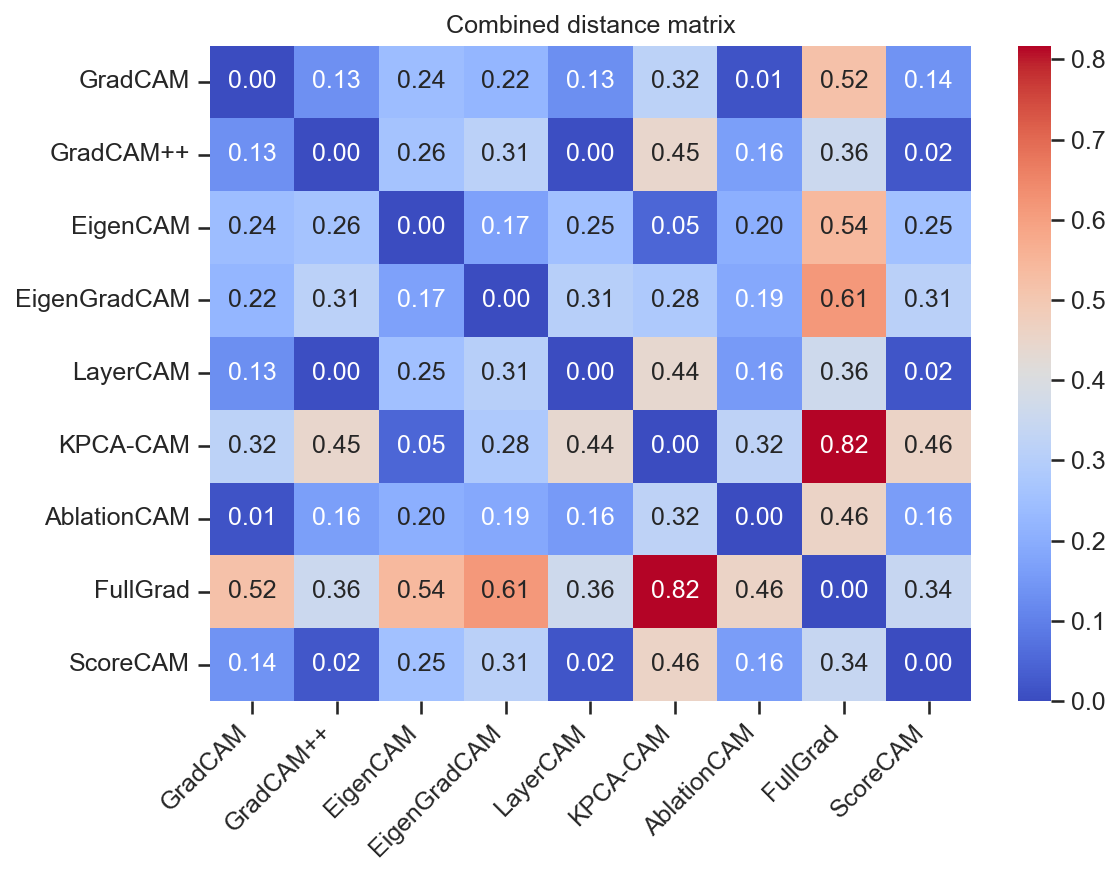

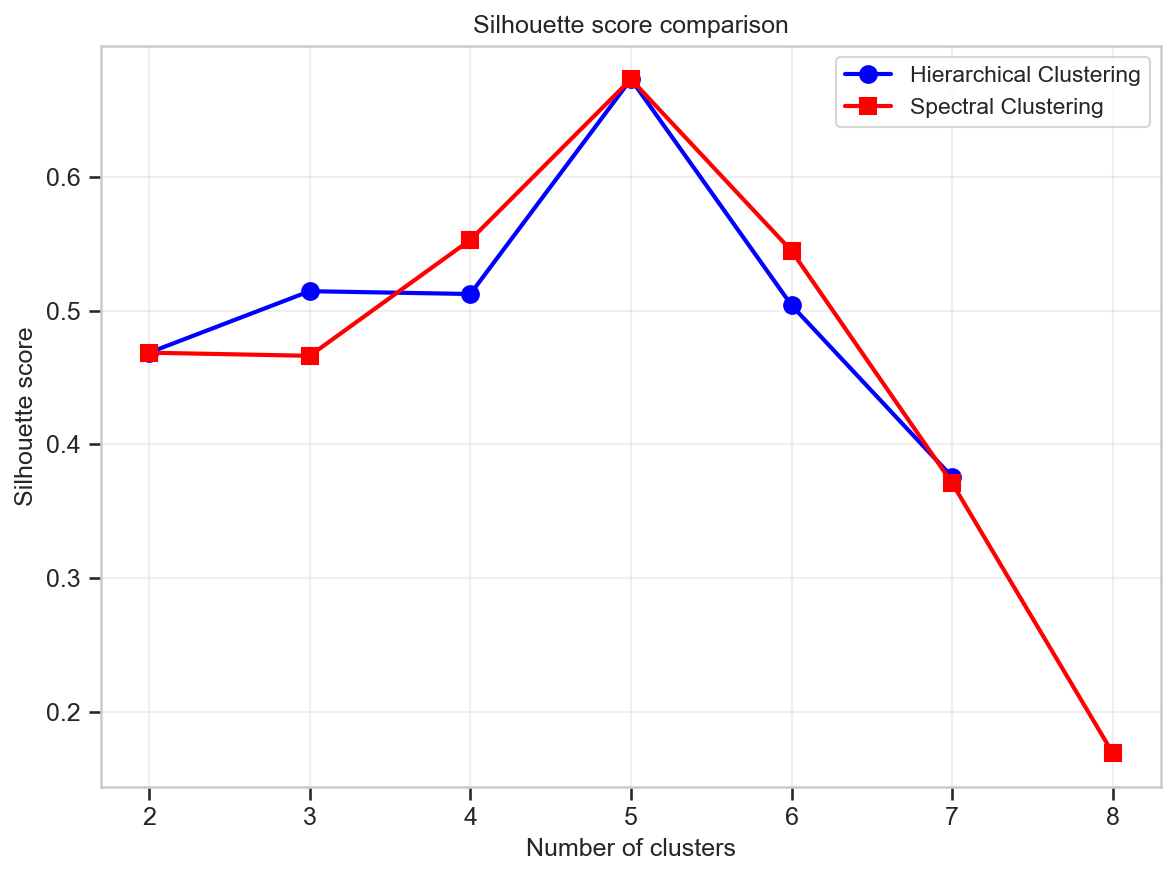

Optimal clusters for hierarchical: 5 (silhouette score: 0.673)
Optimal clusters for spectral: 5 (silhouette score: 0.673)
Optimal clusters for agglomerative: 5 (silhouette score: 0.673)


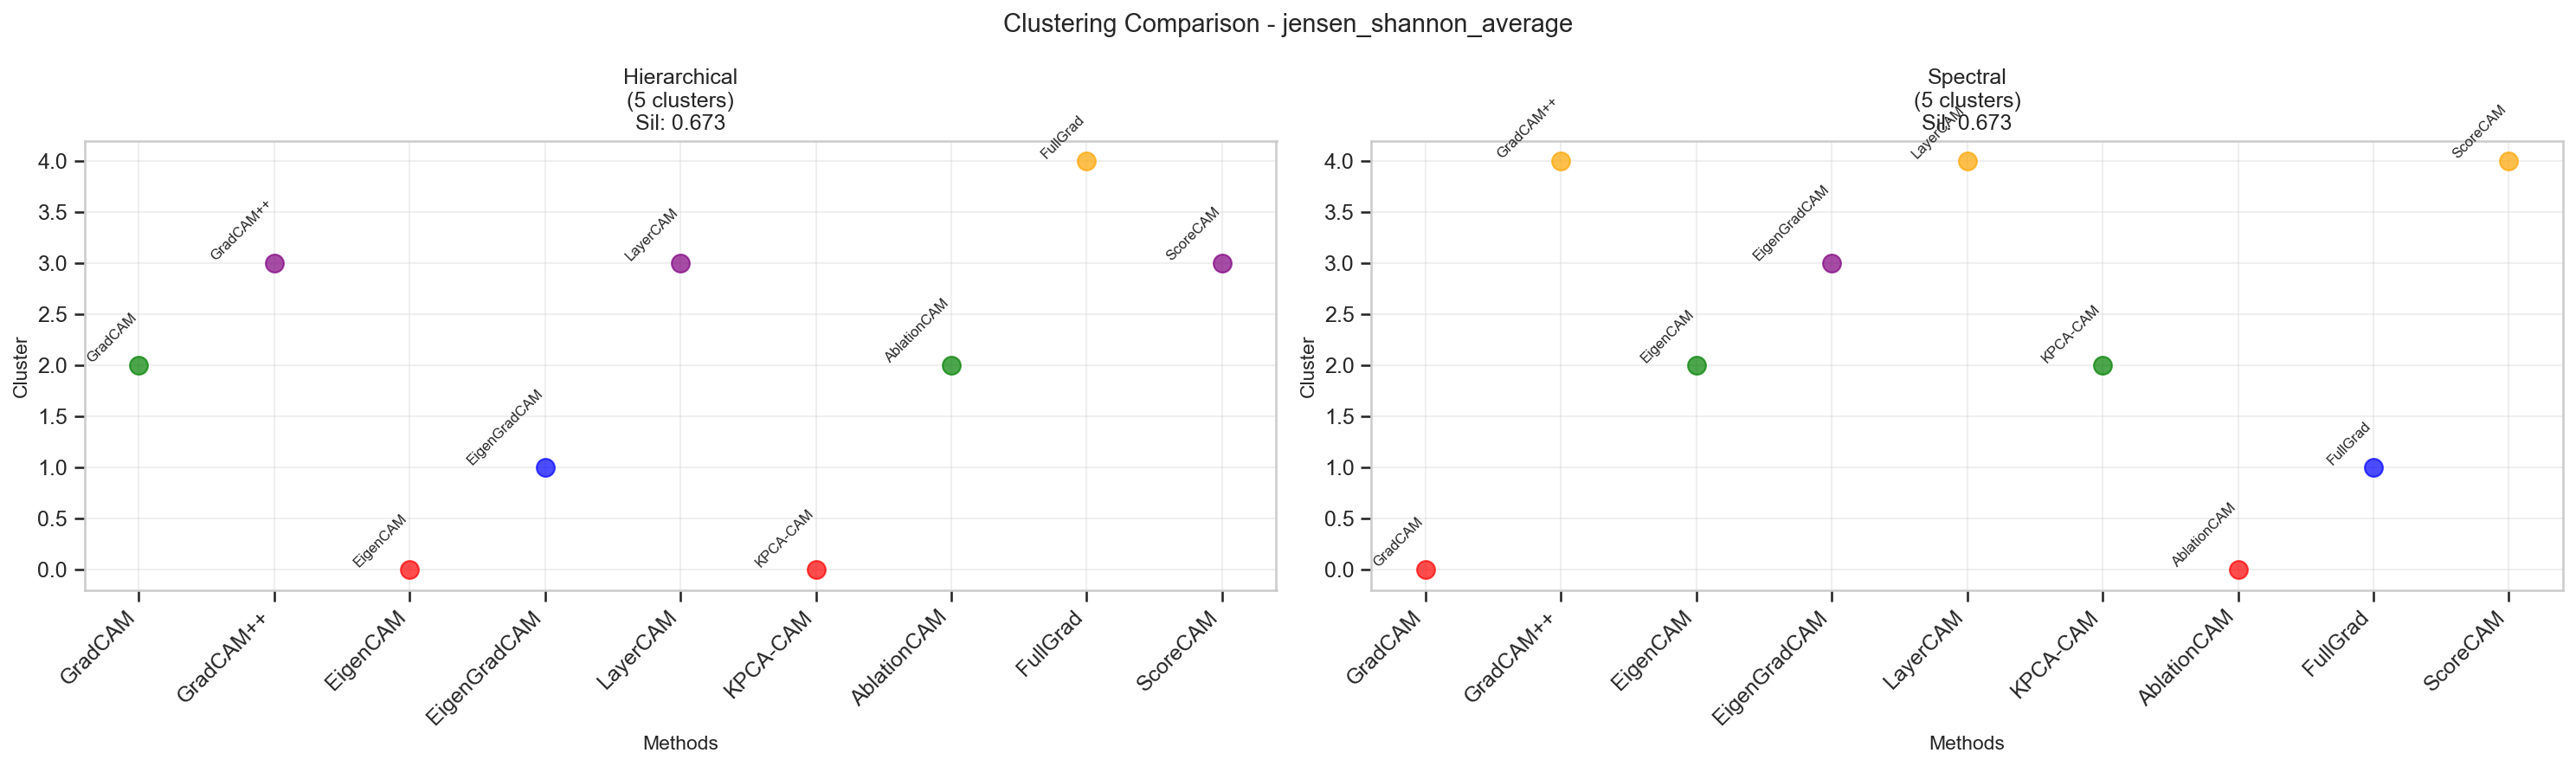

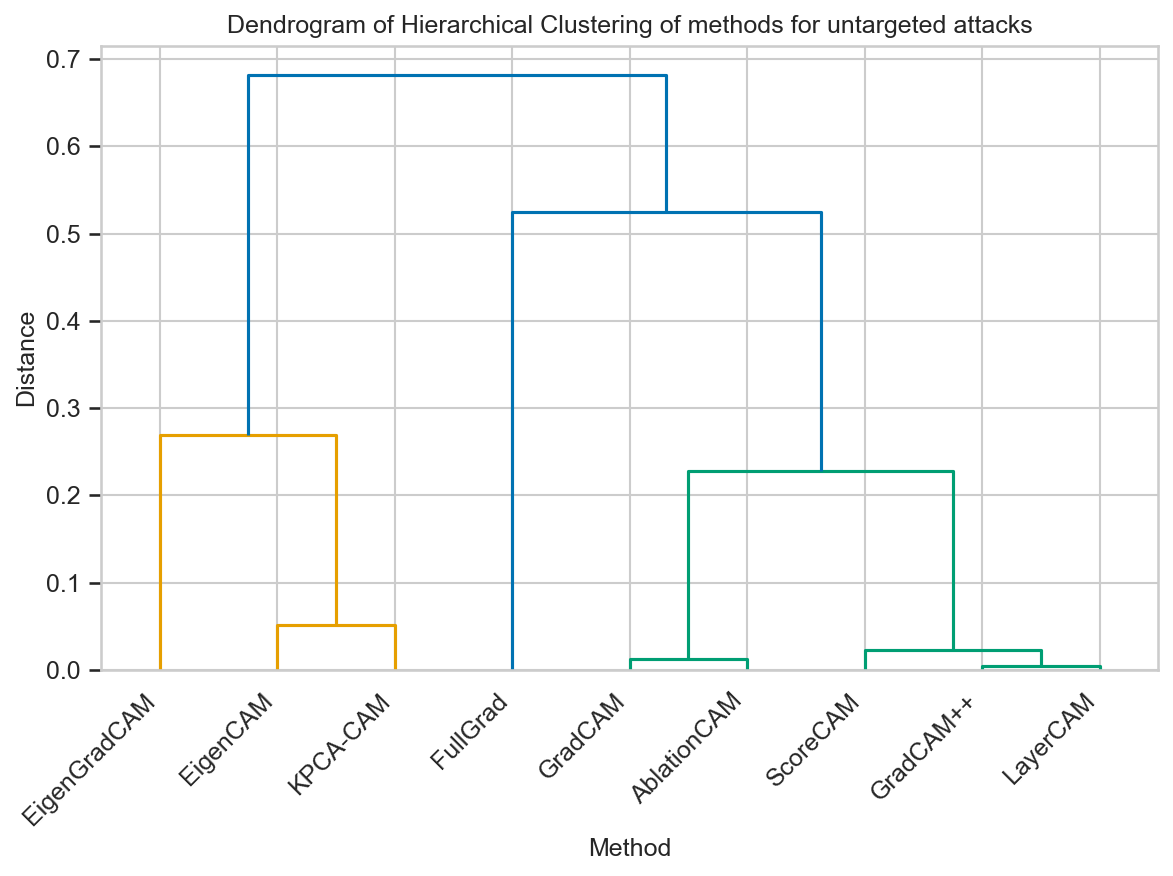

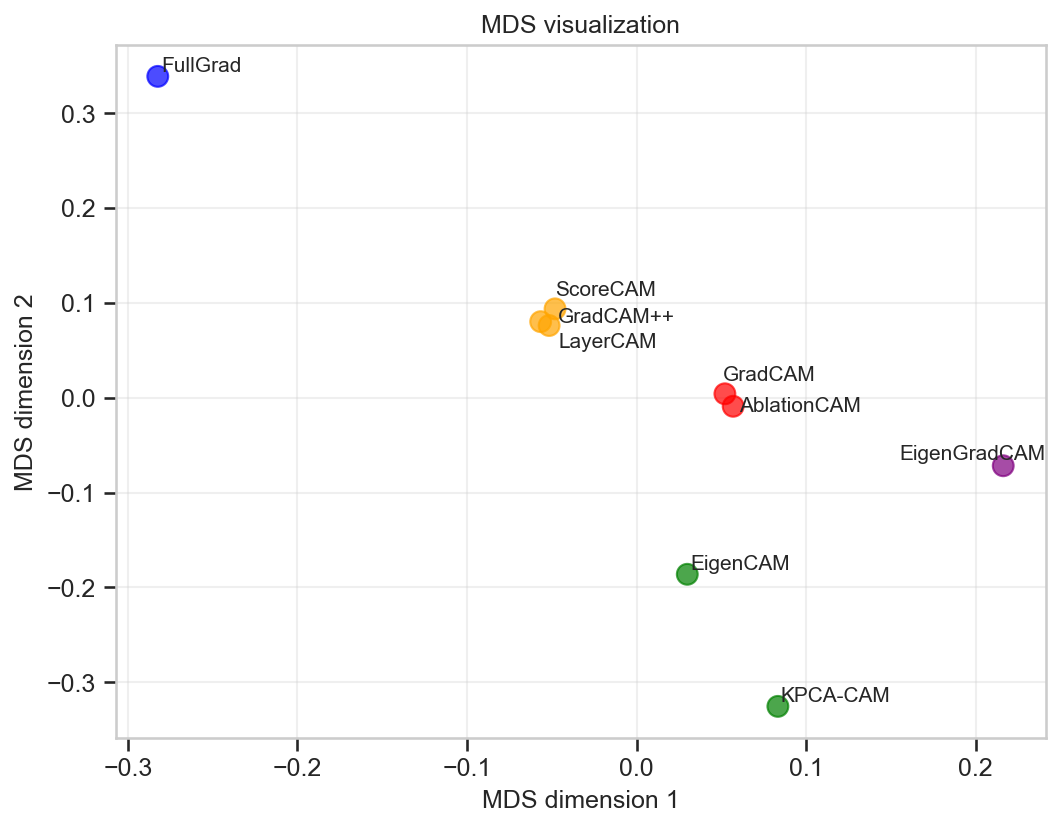


Clustering Summary for jensen_shannon_average:
  hierarchical: 5 clusters (silhouette: 0.673)  spectral: 5 clusters (silhouette: 0.673)

In [54]:
# Initialize the analysis
analyzer = AdversarialAnalysis(results_df)

# Run comprehensive analysis
analyzer.comprehensive_analysis(['average'])

In [59]:
analyzer.clustering_results

{'jensen_shannon_average': {'hierarchical': {'labels': array([3, 4, 1, 2, 4, 1, 3, 5, 4], dtype=int32),
   'n_clusters': 5,
   'silhouette_score': 0.6731156561166061,
   'linkage_matrix': array([[1.00000000e+00, 4.00000000e+00, 4.14253275e-03, 2.00000000e+00],
          [0.00000000e+00, 6.00000000e+00, 1.28651835e-02, 2.00000000e+00],
          [8.00000000e+00, 9.00000000e+00, 2.21575678e-02, 3.00000000e+00],
          [2.00000000e+00, 5.00000000e+00, 5.09113963e-02, 2.00000000e+00],
          [1.00000000e+01, 1.10000000e+01, 2.28263544e-01, 5.00000000e+00],
          [3.00000000e+00, 1.20000000e+01, 2.68554752e-01, 3.00000000e+00],
          [7.00000000e+00, 1.30000000e+01, 5.24669052e-01, 6.00000000e+00],
          [1.40000000e+01, 1.50000000e+01, 6.81471779e-01, 9.00000000e+00]])},
  'spectral': {'labels': array([1, 5, 3, 4, 5, 3, 1, 2, 5], dtype=int32),
   'n_clusters': 5,
   'silhouette_score': 0.6731156561166061}}}

In [76]:
analyzer.methods

array(['GradCAM', 'GradCAM++', 'EigenCAM', 'EigenGradCAM', 'LayerCAM',
       'KPCA-CAM', 'AblationCAM', 'FullGrad', 'ScoreCAM'], dtype=object)

# use random forest classifier to predict clusters based on the metrics

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [26]:
# add cluster information to dataframe

# map label to method
method_to_label = {method: label for label, method in zip(analyzer.clustering_results["jensen_shannon_average"]["hierarchical"]["labels"], analyzer.methods)}
results_df["cluster"] = results_df["method"].map(method_to_label)


--- Predicting cluster ---
Accuracy: 0.8540120651185853
              precision    recall  f1-score   support

           0       0.80      0.84      0.82     40336
           1       0.73      0.62      0.67     20168
           2       0.89      0.84      0.86     40337
           3       0.89      0.94      0.91     60505
           4       0.89      0.88      0.89     20169

    accuracy                           0.85    181515
   macro avg       0.84      0.83      0.83    181515
weighted avg       0.85      0.85      0.85    181515



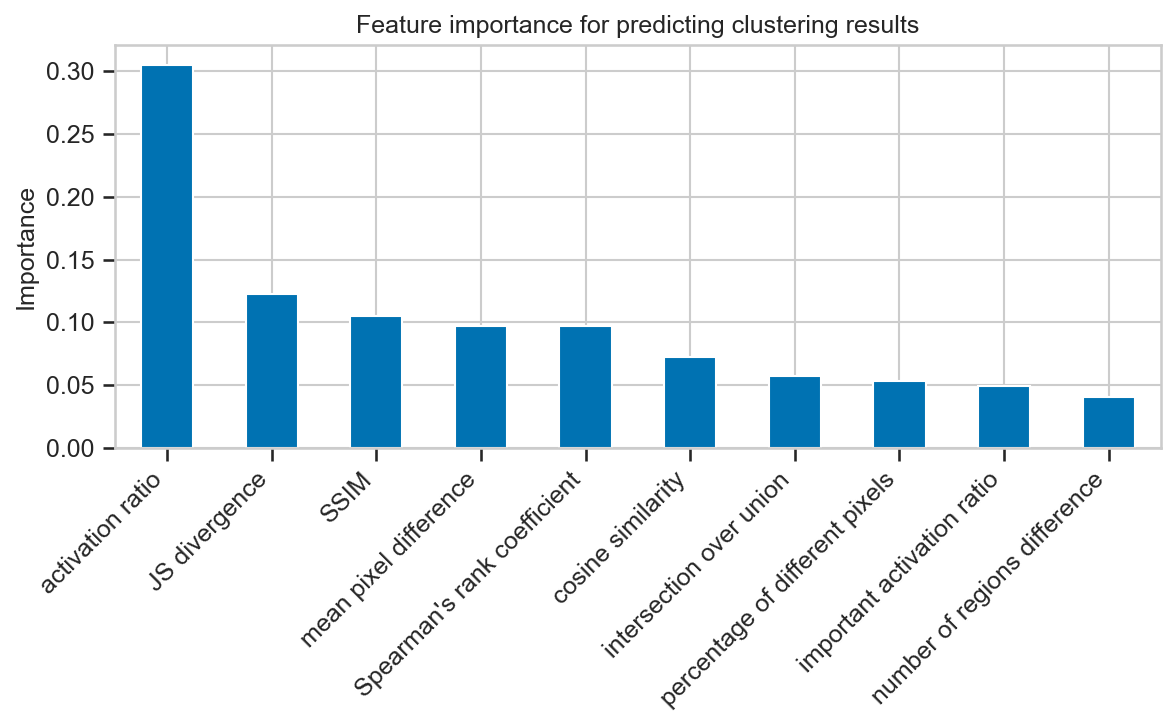

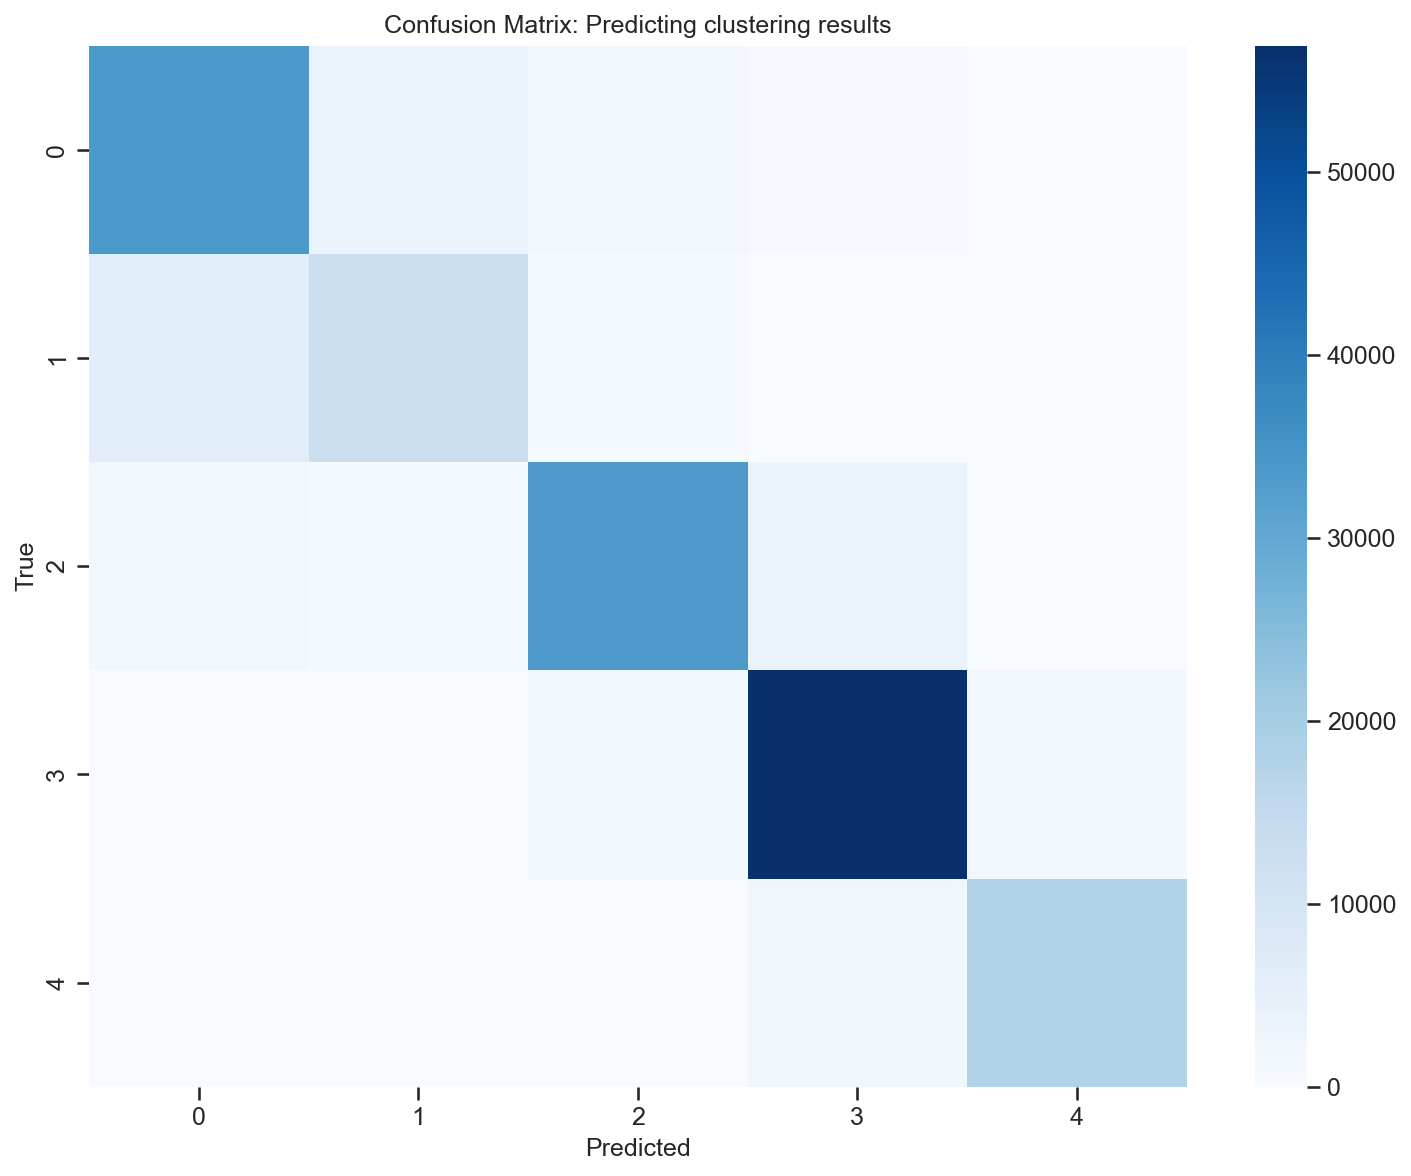

In [37]:
run_rf_classification(results_df, "cluster", "clustering results", metric_columns, save_plot=True)

## Attacks

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, silhouette_samples
from itertools import combinations
from scipy.special import kl_div
from adjustText import adjust_text

class AdversarialAttacksAnalysis:
    def __init__(self, results_df):
        """
        Initialize the analysis with your results dataframe
        """
        self.df = results_df
        self.metric_columns = [
            'mean pixel difference', 'activation ratio', 
            'important activation ratio', 'JS divergence',    
            'number of regions difference'
        ]

        self.attacks = self.df['attack'].unique()
        self.distance_matrices_per_metric = {}
        self.combined_distance_matrices = {}
        self.clustering_results = {}
        self.silhouette_scores = {}


    def jensen_shannon_divergence(self, p, q, bins=20):
        """
        Calculate Jensen-Shannon divergence between two distributions
        """
        # Create histograms with same bins
        min_val = min(np.min(p), np.min(q))
        max_val = max(np.max(p), np.max(q))
        bin_edges = np.linspace(min_val, max_val, bins + 1)
        
        hist_p, _ = np.histogram(p, bins=bin_edges, density=True)
        hist_q, _ = np.histogram(q, bins=bin_edges, density=True)
        
        # Normalize to probabilities
        hist_p = hist_p / np.sum(hist_p)
        hist_q = hist_q / np.sum(hist_q)
        
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10
        hist_p = hist_p + epsilon
        hist_q = hist_q + epsilon
        
        # Calculate M = (P + Q) / 2
        m = (hist_p + hist_q) / 2
        
        # KL divergence
        def kl_divergence(x, y):
            return np.sum(x * np.log(x / y))
        
        # JS divergence
        js_div = 0.5 * kl_divergence(hist_p, m) + 0.5 * kl_divergence(hist_q, m)
        return js_div
    
    def calculate_distance_matrices_per_metric(self):
        """
        Calculate distance matrices for each metric separately
        """
        n_attacks = len(self.attacks)
        
        for metric in self.metric_columns:
            print(f"Calculating distances for {metric}...")
            
            # Initialize distance matrices
            js_matrix = np.zeros((n_attacks, n_attacks))

            # Get distributions for each attack
            attack_distributions = {}
            for attack in self.attacks:
                attack_data = self.df[self.df['attack'] == attack][metric].dropna()
                if len(attack_data) == 0:
                    print(f"Warning: No data for attack {attack} and metric {metric}")
                    continue
                attack_distributions[attack] = attack_data.values

            # Calculate pairwise distances
            for i, attack1 in enumerate(self.attacks):
                for j, attack2 in enumerate(self.attacks):
                    if i == j:
                        js_matrix[i, j] = 0
                  
                    else:
                        if attack1 in attack_distributions and attack2 in attack_distributions:
                            dist1 = attack_distributions[attack1]
                            dist2 = attack_distributions[attack2]

                            # Jensen-Shannon divergence
                            js_matrix[i, j] = self.jensen_shannon_divergence(dist1, dist2)

              
            self.distance_matrices_per_metric[metric] = {
                'jensen_shannon': js_matrix
            }
    
    def combine_distance_matrices(self, combination_method='average'):
        """
        Combine distance matrices across all metrics
        
        combination_method options:
        - 'average': Simple average of distances across metrics
        - 'weighted_average': Weighted by inverse of metric variance
        - 'max': Maximum distance across metrics
        - 'euclidean': Euclidean distance in metric space
        """
        n_attacks = len(self.attacks)
        n_metrics = len(self.metric_columns)

        for distance_type in ['jensen_shannon']:
            if combination_method == 'average':
                # Simple average
                combined_matrix = np.zeros((n_attacks, n_attacks))
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        D = self.distance_matrices_per_metric[metric][distance_type]

                        # Compute robust min/max using percentiles
                        p_low, p_high = np.percentile(D, [0.05, 99.5])
                        D_norm = np.clip((D - p_low) / (p_high - p_low), 0, 1)  # clip to [0,1]

                        combined_matrix += D_norm
                        #combined_matrix += self.distance_matrices_per_metric[metric][distance_type]
                combined_matrix /= len(self.metric_columns)
                
            elif combination_method == 'weighted_average':
                # Weighted by inverse variance of each metric
                weights = []
                matrices = []
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        matrix = self.distance_matrices_per_metric[metric][distance_type]
                        # Calculate weight as inverse of variance
                        variance = np.var(matrix[matrix > 0])
                        weight = 1.0 / (variance + 1e-10)  # Add small epsilon to avoid division by zero
                        weights.append(weight)
                        matrices.append(matrix)
                
                weights = np.array(weights)
                weights = weights / np.sum(weights)  # Normalize weights

                combined_matrix = np.zeros((n_attacks, n_attacks))
                for weight, matrix in zip(weights, matrices):
                    combined_matrix += weight * matrix
                    
            elif combination_method == 'max':
                # Maximum distance across metrics
                combined_matrix = np.zeros((n_attacks, n_attacks))
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        matrix = self.distance_matrices_per_metric[metric][distance_type]
                        combined_matrix = np.maximum(combined_matrix, matrix)
                        
            elif combination_method == 'euclidean':
                # Euclidean distance in metric space
                combined_matrix = np.zeros((n_attacks, n_attacks))
                for i in range(n_attacks):
                    for j in range(n_attacks):
                        if i != j:
                            distances = []
                            for metric in self.metric_columns:
                                if metric in self.distance_matrices_per_metric:
                                    distances.append(self.distance_matrices_per_metric[metric][distance_type][i, j])
                            combined_matrix[i, j] = np.sqrt(np.sum(np.array(distances)**2))
            
            self.combined_distance_matrices[f"{distance_type}_{combination_method}"] = combined_matrix
            
        print(f"Combined distance matrices using {combination_method} method")
    
    def calculate_silhouette_scores(self, distance_matrix_key, max_clusters=33):
        """
        Calculate silhouette scores for different numbers of clusters
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        silhouette_scores = {}
        
        for n_clusters in range(2, min(len(self.attacks), max_clusters + 1)):
            scores = {}
            
            # Hierarchical clustering
            linkage_matrix = linkage(squareform(distance_matrix), method='ward')
            hier_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
            if len(np.unique(hier_labels)) == n_clusters:  # Check if we got the expected number of clusters
                scores['hierarchical'] = silhouette_score(distance_matrix, hier_labels, metric='precomputed')
            
            # Spectral clustering
            try:
                sigma = np.median(distance_matrix[distance_matrix > 0])
                affinity_matrix = np.exp(-distance_matrix / (2 * sigma**2))
                np.fill_diagonal(affinity_matrix, 1)
                
                spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
                spec_labels = spectral.fit_predict(affinity_matrix)
                if len(np.unique(spec_labels)) == n_clusters:
                    scores['spectral'] = silhouette_score(distance_matrix, spec_labels, metric='precomputed')
            except Exception as e:
                print(f"Spectral clustering failed for {n_clusters} clusters: {e}")
            
            # Agglomerative clustering
            try:
                agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                                       metric='precomputed', 
                                                       linkage='average')
                agg_labels = agg_clustering.fit_predict(distance_matrix)
                if len(np.unique(agg_labels)) == n_clusters:
                    scores['agglomerative'] = silhouette_score(distance_matrix, agg_labels, metric='precomputed')
            except Exception as e:
                print(f"Agglomerative clustering failed for {n_clusters} clusters: {e}")
            
            silhouette_scores[n_clusters] = scores
        
        self.silhouette_scores[distance_matrix_key] = silhouette_scores
        return silhouette_scores
    
    
    def perform_clustering_with_optimal_clusters(self, distance_matrix_key, num_clusters=None):
        """
        Perform clustering using optimal number of clusters based on silhouette scores
        """
        if distance_matrix_key not in self.silhouette_scores:
            self.calculate_silhouette_scores(distance_matrix_key)
        
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        results = {}
        
        # Find optimal clusters for other methods
        silhouette_data = self.silhouette_scores[distance_matrix_key]
        
        for method in ['hierarchical', 'spectral', 'agglomerative']:
            method_scores = {k: v.get(method, -1) for k, v in silhouette_data.items()}
            if num_clusters is not None:
                optimal_clusters = num_clusters
            else:
                optimal_clusters = max(method_scores, key=method_scores.get)

            print(f"Optimal clusters for {method}: {optimal_clusters} (silhouette score: {method_scores[optimal_clusters]:.3f})")
            
            if method == 'hierarchical':
                linkage_matrix = linkage(squareform(distance_matrix), method='ward')
                labels = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')
                results[method] = {
                    'labels': labels,
                    'n_clusters': optimal_clusters,
                    'silhouette_score': method_scores[optimal_clusters],
                    'linkage_matrix': linkage_matrix
                }
            elif method == 'spectral':
                sigma = np.median(distance_matrix[distance_matrix > 0])
                affinity_matrix = np.exp(-distance_matrix / (2 * sigma**2))
                np.fill_diagonal(affinity_matrix, 1)
                
                spectral = SpectralClustering(n_clusters=optimal_clusters, affinity='precomputed', 
                                            random_state=42)
                labels = spectral.fit_predict(affinity_matrix) + 1
                results[method] = {
                    'labels': labels,
                    'n_clusters': optimal_clusters,
                    'silhouette_score': method_scores[optimal_clusters]
                }
        
        self.clustering_results[distance_matrix_key] = results
        return results
    
    def plot_silhouette_analysis(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot silhouette scores for different numbers of clusters
        """
        if distance_matrix_key not in self.silhouette_scores:
            self.calculate_silhouette_scores(distance_matrix_key)
        
        silhouette_data = self.silhouette_scores[distance_matrix_key]
        
        plt.figure(figsize=figsize)

        methods = ['hierarchical', 'spectral']
        colors = ['blue', 'red']
        markers = ['o', 's']

        # Plot both methods on the same plot
        for idx, method in enumerate(methods):
            clusters = []
            scores = []
            for n_clusters, method_scores in silhouette_data.items():
                if method in method_scores:
                    clusters.append(n_clusters)
                    scores.append(method_scores[method])
            
            if clusters:
                plt.plot(clusters, scores, marker=markers[idx], color=colors[idx], 
                        linewidth=2, markersize=8, label=f'{method.title()} Clustering')

        plt.title(f'Silhouette score comparison')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette score')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"results/big_dataset/untargeted/silhouette_analysis_{distance_matrix_key}_attacks.svg")
        plt.show()
    
    def plot_combined_distance_heatmap(self, distance_matrix_key, figsize=(20, 15)):
        """
        Plot heatmap of combined distance matrix
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        
        plt.figure(figsize=figsize)
        sns.heatmap(distance_matrix, 
                   xticklabels=self.attacks, yticklabels=self.attacks,
                   annot=True, fmt='.2f', cmap='coolwarm')
        plt.title(f'Combined distance matrix')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"results/big_dataset/untargeted/combined_distance_matrix_attacks.svg")
        plt.show()
    
    def plot_clustering_comparison(self, distance_matrix_key, figsize=(20, 6)):
        """
        Compare clustering results across different methods
        """
        if distance_matrix_key not in self.clustering_results:
            self.perform_clustering_with_optimal_clusters(distance_matrix_key)
        
        results = self.clustering_results[distance_matrix_key]
        
        
        clustering_methods = ['hierarchical', 'spectral']
        fig, axes = plt.subplots(1, len(clustering_methods), figsize=figsize)
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive']
        
        for idx, clustering_method in enumerate(clustering_methods):
            if clustering_method in results:
                labels = results[clustering_method]['labels']
                n_clusters = results[clustering_method]['n_clusters']
                
                # Create scatter plot showing cluster assignments
                x_pos = range(len(self.attacks))

                for i, attack in enumerate(self.attacks):
                    cluster_id = labels[i] - 1 if hasattr(labels, '__getitem__') else labels - 1
                    axes[idx].scatter(i, cluster_id, c=colors[cluster_id % len(colors)], s=100, alpha=0.7)
                    axes[idx].text(i, cluster_id, attack, rotation=45, ha='right', va='bottom', fontsize=8)

                title = f'{clustering_method.replace("_", " ").title()}\n({n_clusters} clusters)'
                if 'silhouette_score' in results[clustering_method]:
                    title += f'\nSil: {results[clustering_method]["silhouette_score"]:.3f}'
                
                axes[idx].set_title(title)
                axes[idx].set_xlabel('Attacks')
                axes[idx].set_ylabel('Cluster')
                axes[idx].set_xticks(range(len(self.attacks)))
                axes[idx].set_xticklabels(self.attacks, rotation=45, ha='right')
                axes[idx].grid(True, alpha=0.3)
        
        plt.suptitle(f'Clustering Comparison - {distance_matrix_key}')
        plt.tight_layout()
        plt.show()
    
    def plot_dendrogram(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot dendrogram for hierarchical clustering
        """
        if distance_matrix_key not in self.clustering_results:
            self.perform_clustering_with_optimal_clusters(distance_matrix_key)
        
        plt.figure(figsize=figsize)
        linkage_matrix = self.clustering_results[distance_matrix_key]['hierarchical']['linkage_matrix']
        
        dendrogram(linkage_matrix, labels=self.attacks, leaf_rotation=90, leaf_font_size=12)
        plt.title(f'Dendrogram of Hierarchical Clustering of untargeted attacks')
        plt.ylabel('Distance')
        plt.xlabel('Attack')
        plt.tight_layout()
        plt.savefig(f"results/big_dataset/untargeted/dendrogram_{distance_matrix_key}_attacks.svg")
        plt.show()
    
    def mds_visualization(self, distance_matrix_key, figsize=(8, 6)):
        """
        Visualize methods using MDS based on combined distance matrix
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        
        # Perform MDS
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        coords = mds.fit_transform(distance_matrix)
        
        # Get cluster colors if clustering results exist
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive']
        if distance_matrix_key in self.clustering_results:
            # Use spectral clustering results for coloring
            labels = self.clustering_results[distance_matrix_key]['spectral']['labels']
            point_colors = [colors[(label - 1) % len(colors)] for label in labels]
        else:
            point_colors = 'blue'
        
        plt.figure(figsize=figsize)
        plt.scatter(coords[:, 0], coords[:, 1], s=100, alpha=0.7, c=point_colors)

        texts = []

        for i, attack in enumerate(self.attacks):
            texts.append(plt.annotate(attack, (coords[i, 0], coords[i, 1]),
                     fontsize=10)
                )

        adjust_text(texts)
        plt.title(f'MDS visualization')
        plt.xlabel('MDS dimension 1')
        plt.ylabel('MDS dimension 2')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def comprehensive_analysis(self, combination_methods=['average', 'weighted_average']):
        """
        Run comprehensive analysis with all combination methods
        """
        print("=== COMPREHENSIVE ADVERSARIAL ATTACK ANALYSIS ===\n")
        
        # Calculate distance matrices per metric
        self.calculate_distance_matrices_per_metric()
        
        # Try different combination methods
        for comb_method in combination_methods:
            print(f"\n{'='*60}")
            print(f"ANALYSIS WITH {comb_method.upper()} COMBINATION METHOD")
            print('='*60)
            
            # Combine matrices
            self.combine_distance_matrices(comb_method)
            
            # Analyze both distance types
            for distance_type in ['jensen_shannon']:
                matrix_key = f"{distance_type}_{comb_method}"
                
                print(f"\n--- {distance_type.title()} Distance ---")
                
                # Plot combined distance heatmap
                self.plot_combined_distance_heatmap(matrix_key)
                
                # Calculate silhouette scores
                self.calculate_silhouette_scores(matrix_key)
                
                # Plot silhouette analysis
                self.plot_silhouette_analysis(matrix_key)
                
                # Perform clustering with optimal number of clusters
                results = self.perform_clustering_with_optimal_clusters(matrix_key)
                
                # Visualizations
                self.plot_clustering_comparison(matrix_key)
                self.plot_dendrogram(matrix_key)
                self.mds_visualization(matrix_key)
                
                # Print summary
                print(f"\nClustering Summary for {matrix_key}:")
                for method, result in results.items():
                    print(f"  {method}: {result['n_clusters']} clusters", end="")
                    if 'silhouette_score' in result:
                        print(f" (silhouette: {result['silhouette_score']:.3f})", end="")

    def summary_report(self):
        """
        Generate a summary report
        """
        print("=== ADVERSARIAL ATTACK ANALYSIS SUMMARY ===\n")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Number of attacks: {len(self.attacks)}")
        print(f"Attacks: {', '.join(self.attacks)}")
        print(f"Number of images: {len(self.df['image ID'].unique())}")
        print(f"Metrics analyzed: {len(self.metric_columns)}")
        
        print("\n=== BASIC STATISTICS ===")
        for metric in self.metric_columns:
            print(f"\n{metric}:")
            stats_df = self.df.groupby('method')[metric].agg(['count', 'mean', 'std', 'median']).round(4)
            print(stats_df)


In [18]:
# filter dataframe such that every attack has the same number of samples (common image IDs)
# Get all unique attacks
all_attacks = results_df['attack'].unique()

# For each attack, find the set of image IDs that have results
image_sets_per_attack = [
    set(results_df[results_df['attack'] == attack]['image ID'].unique())
    for attack in all_attacks
]

# Intersection: images common to all attacks
common_image_ids = set.intersection(*image_sets_per_attack)
print(f"Number of images with successful adversarial examples for all attacks: {len(common_image_ids)}")
attack_df = results_df[results_df['image ID'].isin(common_image_ids)].copy()

Number of images with successful adversarial examples for all attacks: 783


=== COMPREHENSIVE ADVERSARIAL ATTACK ANALYSIS ===

Calculating distances for mean pixel difference...
Calculating distances for activation ratio...
Calculating distances for important activation ratio...
Calculating distances for JS divergence...
Calculating distances for number of regions difference...

ANALYSIS WITH AVERAGE COMBINATION METHOD
Combined distance matrices using average method

--- Jensen_Shannon Distance ---


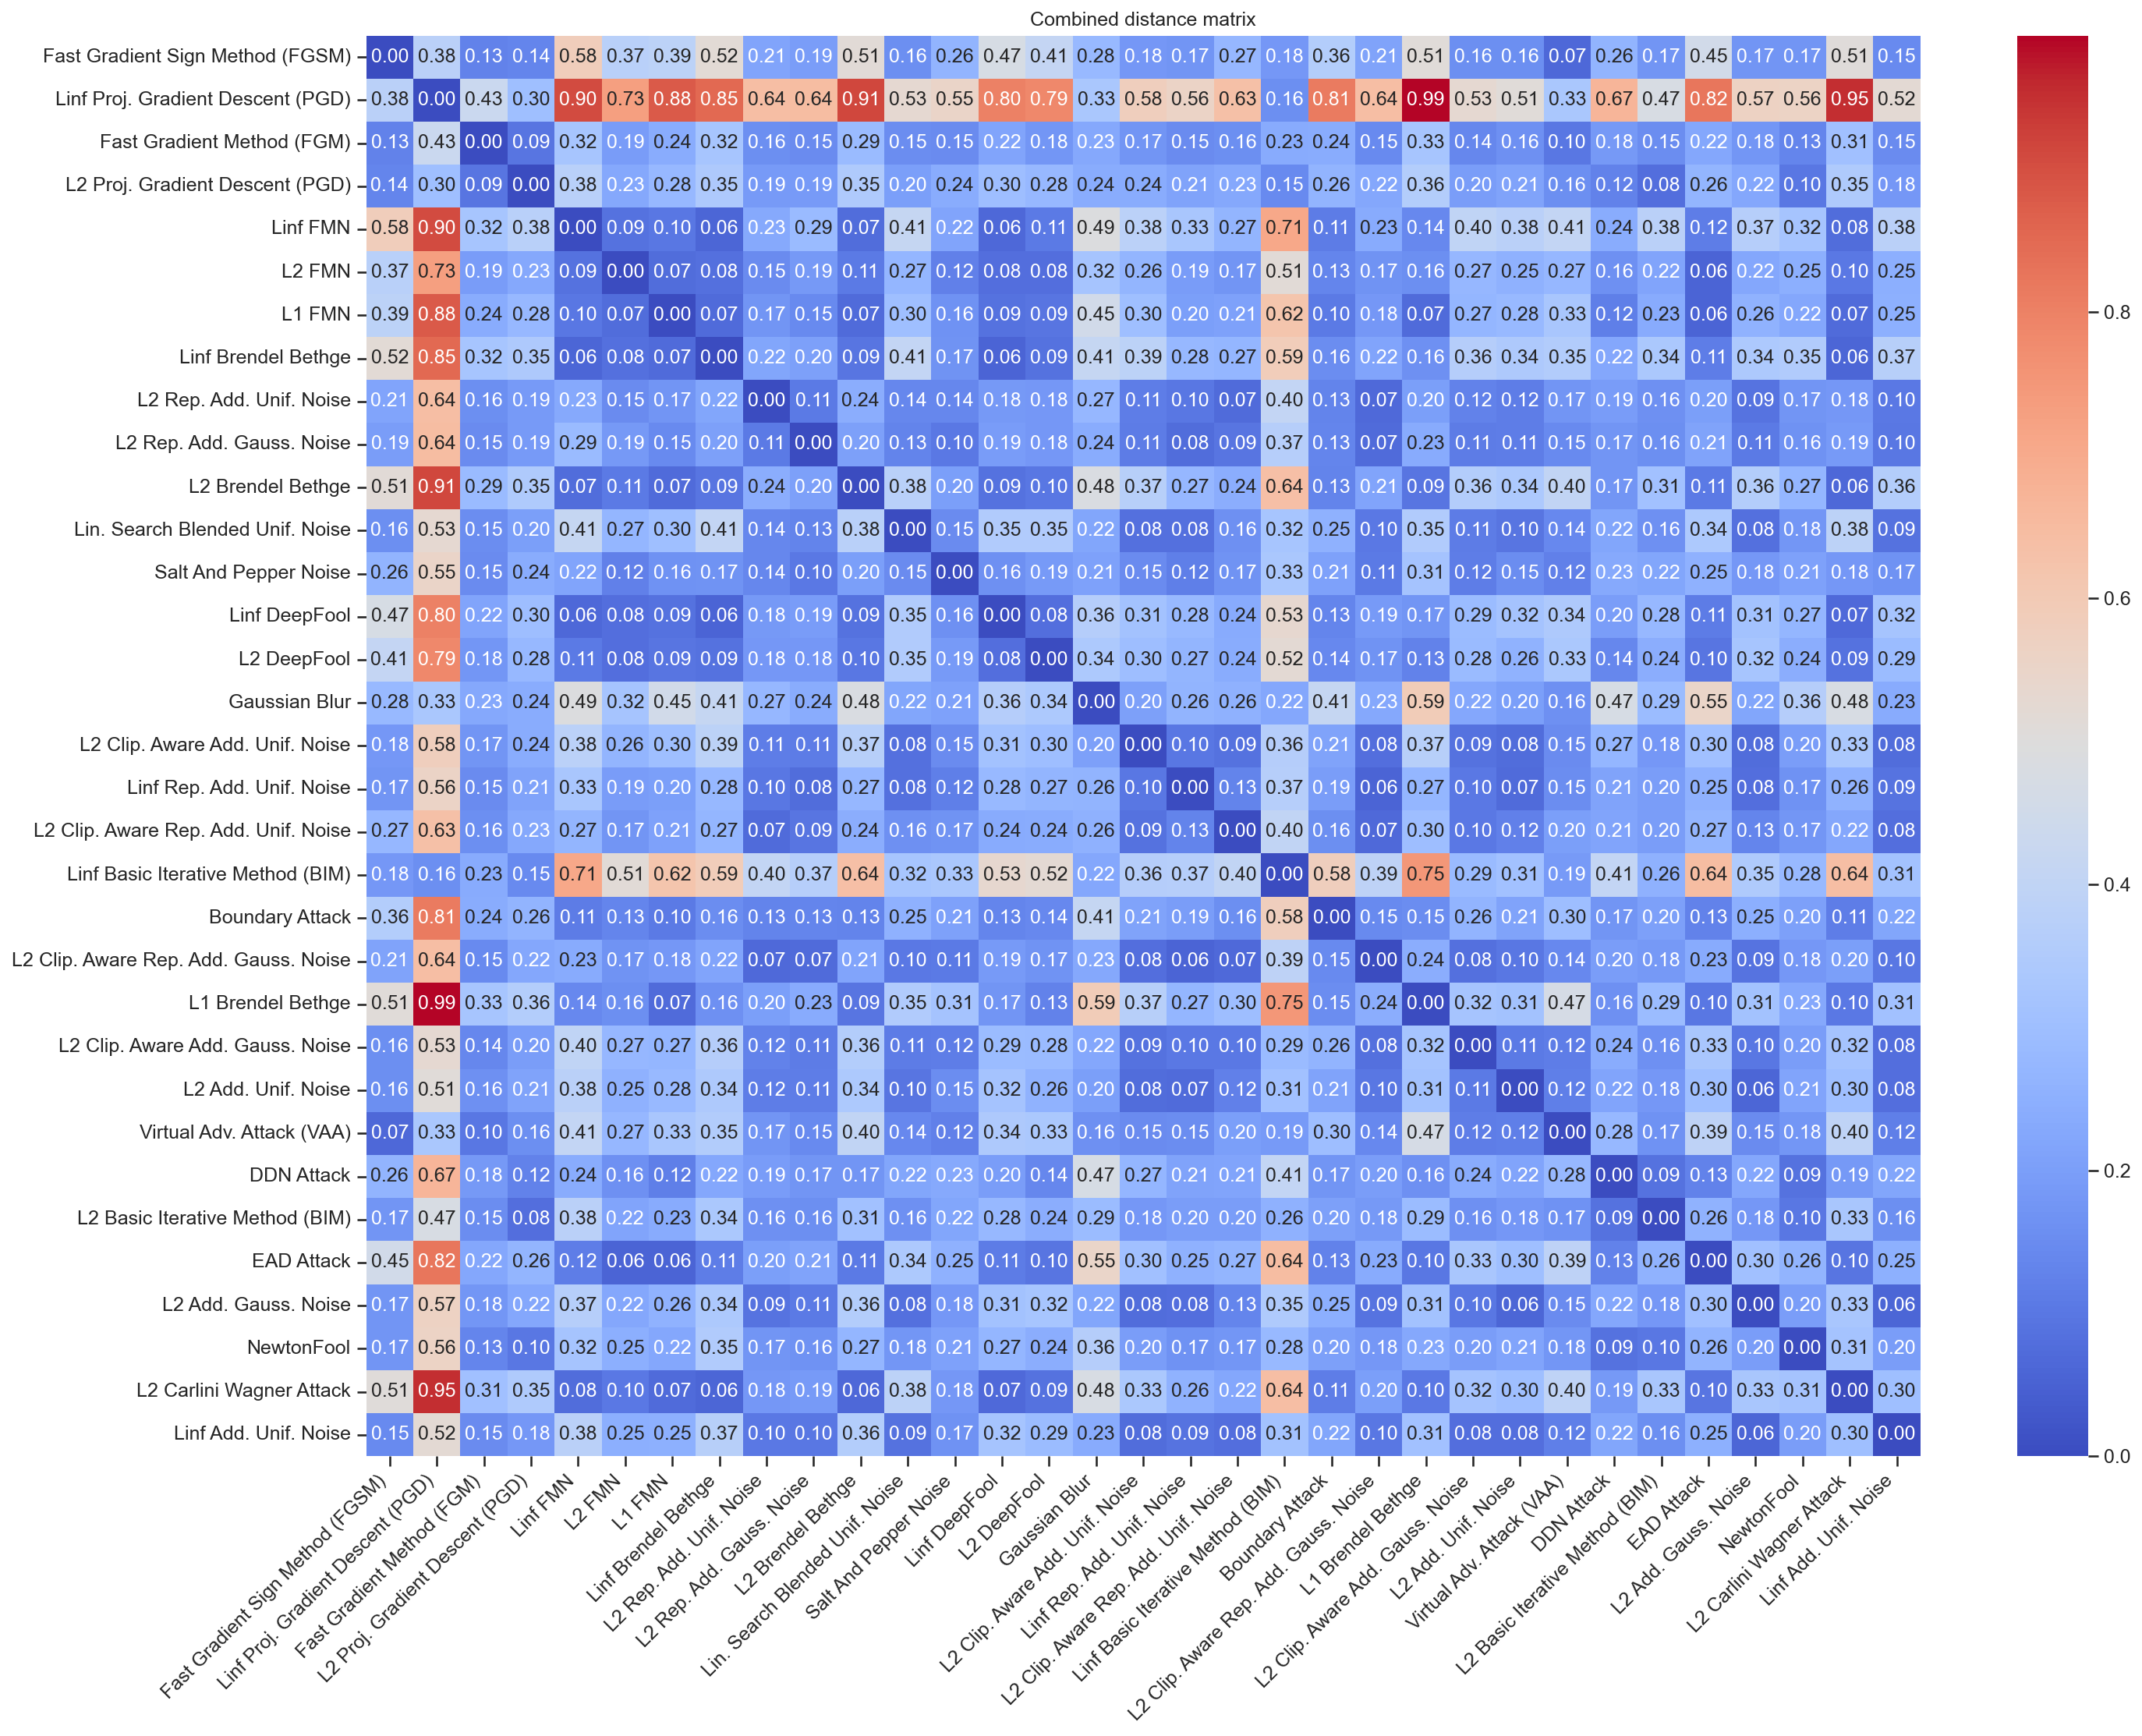

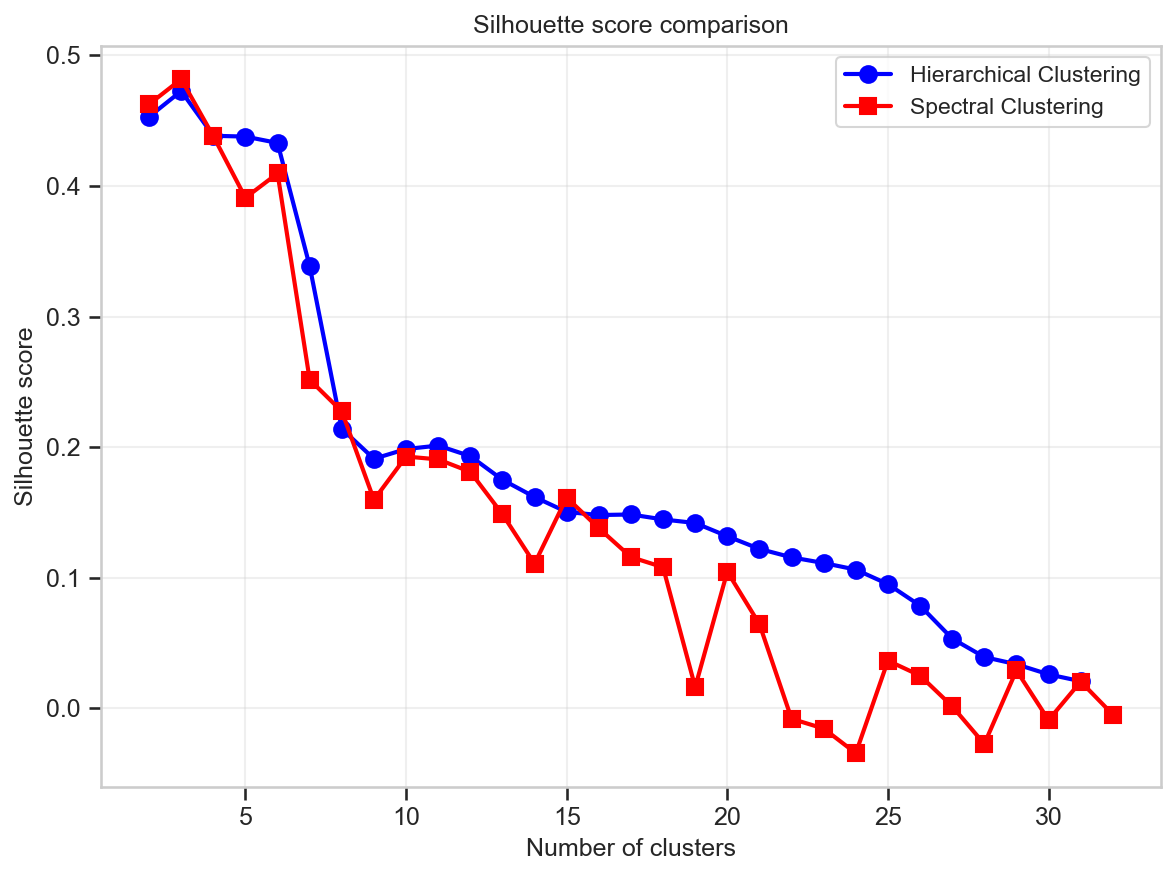

Optimal clusters for hierarchical: 3 (silhouette score: 0.473)
Optimal clusters for spectral: 3 (silhouette score: 0.482)
Optimal clusters for agglomerative: 2 (silhouette score: 0.548)


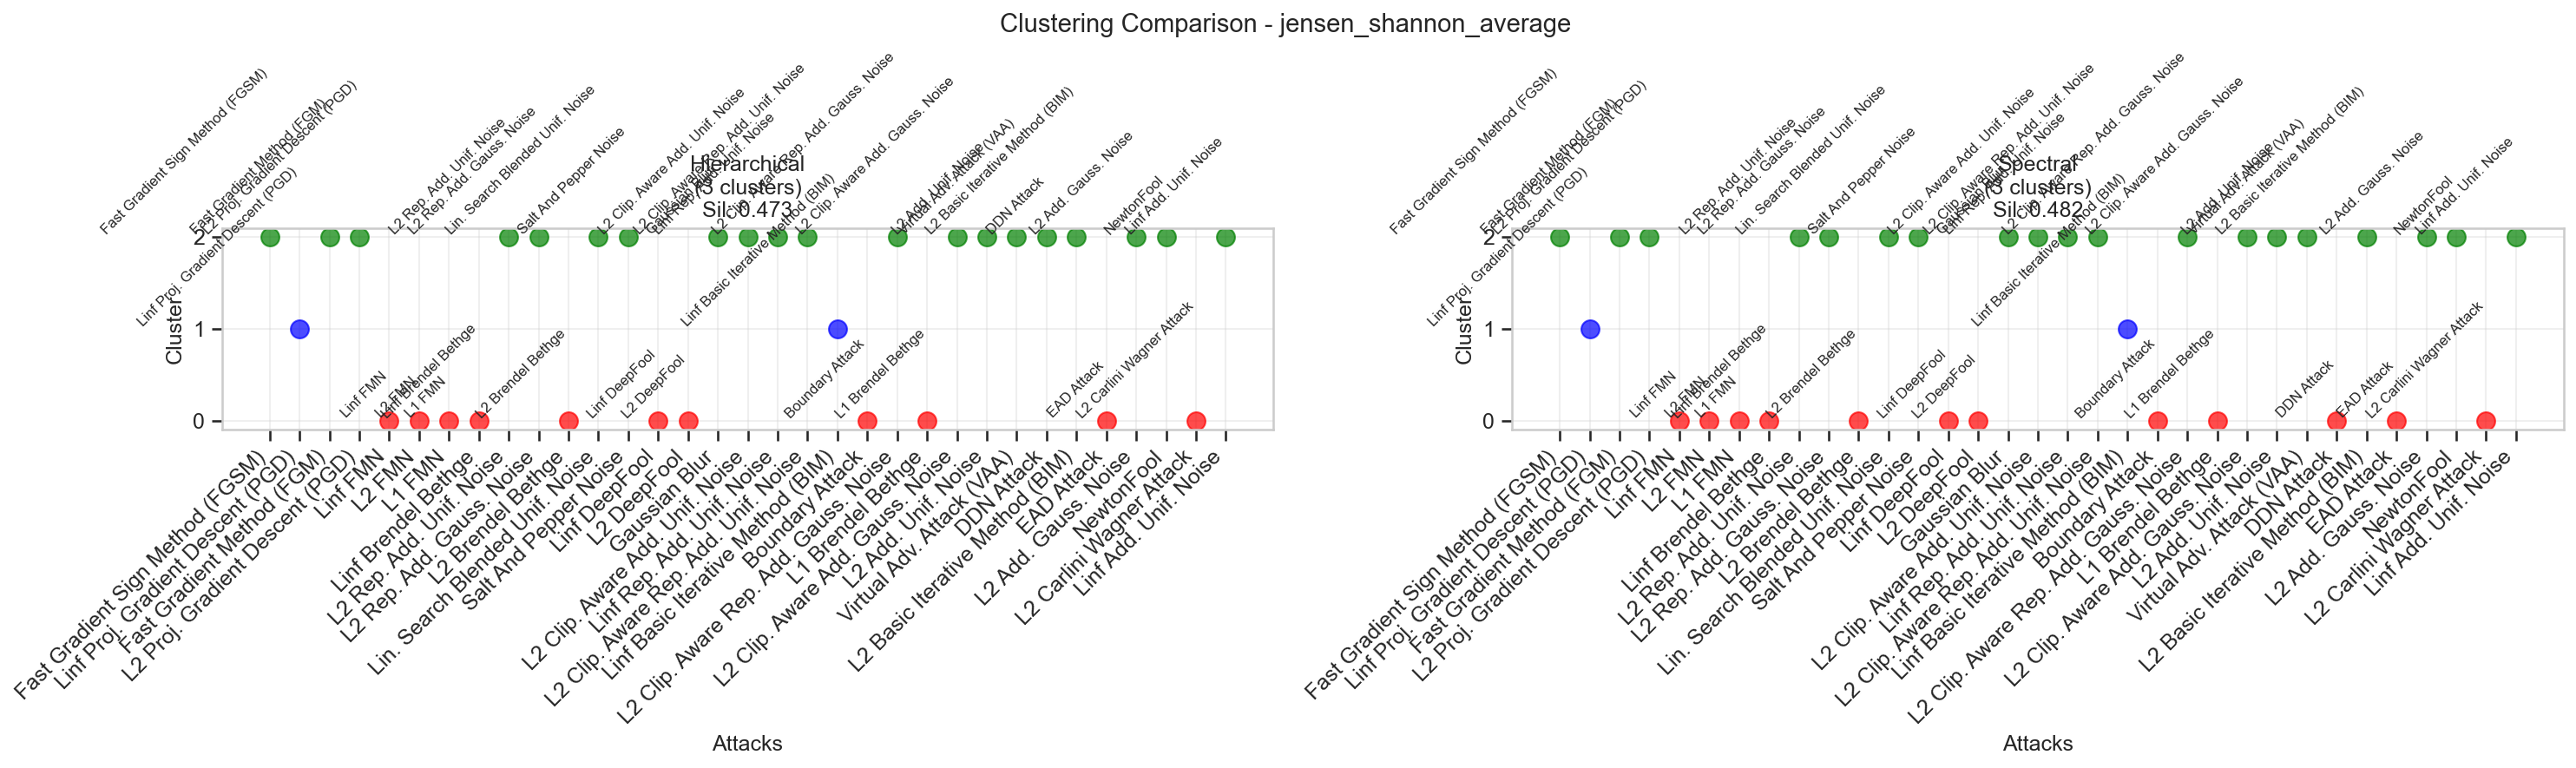

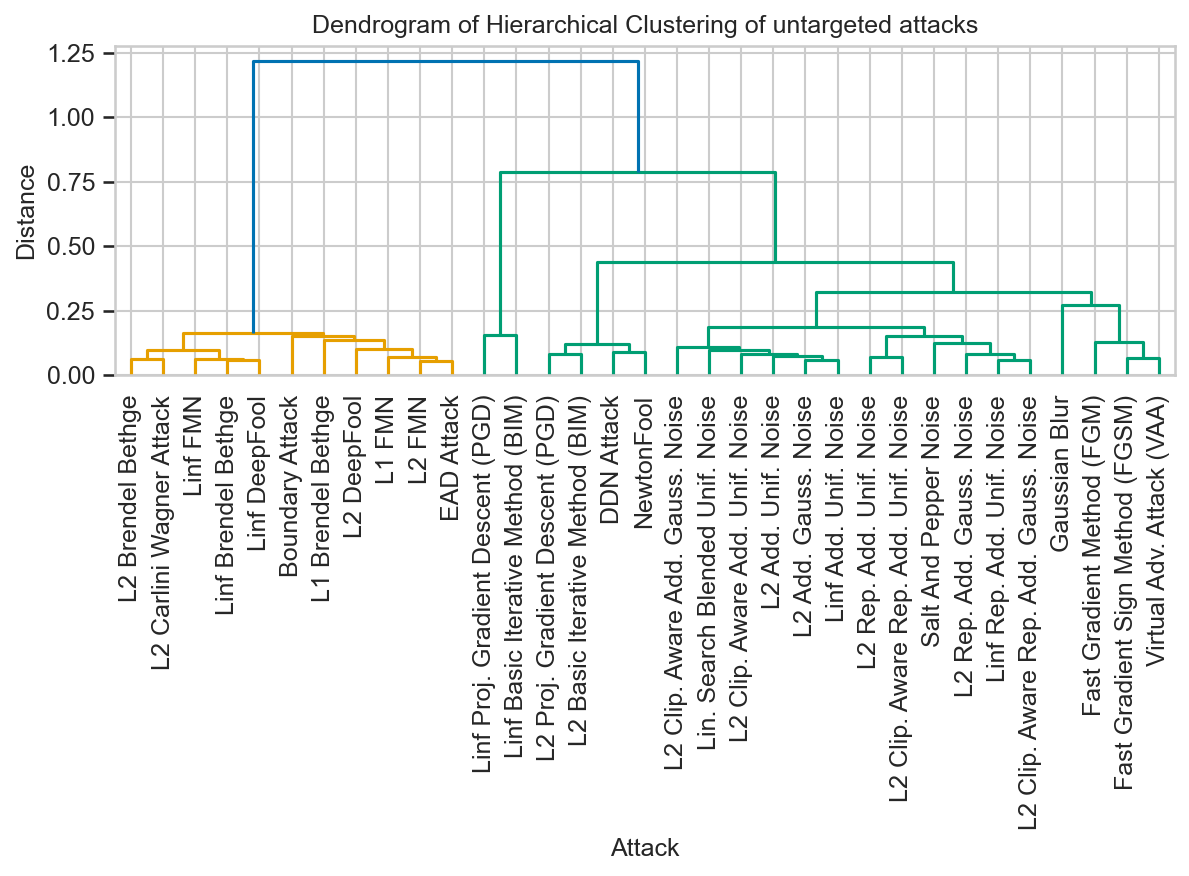

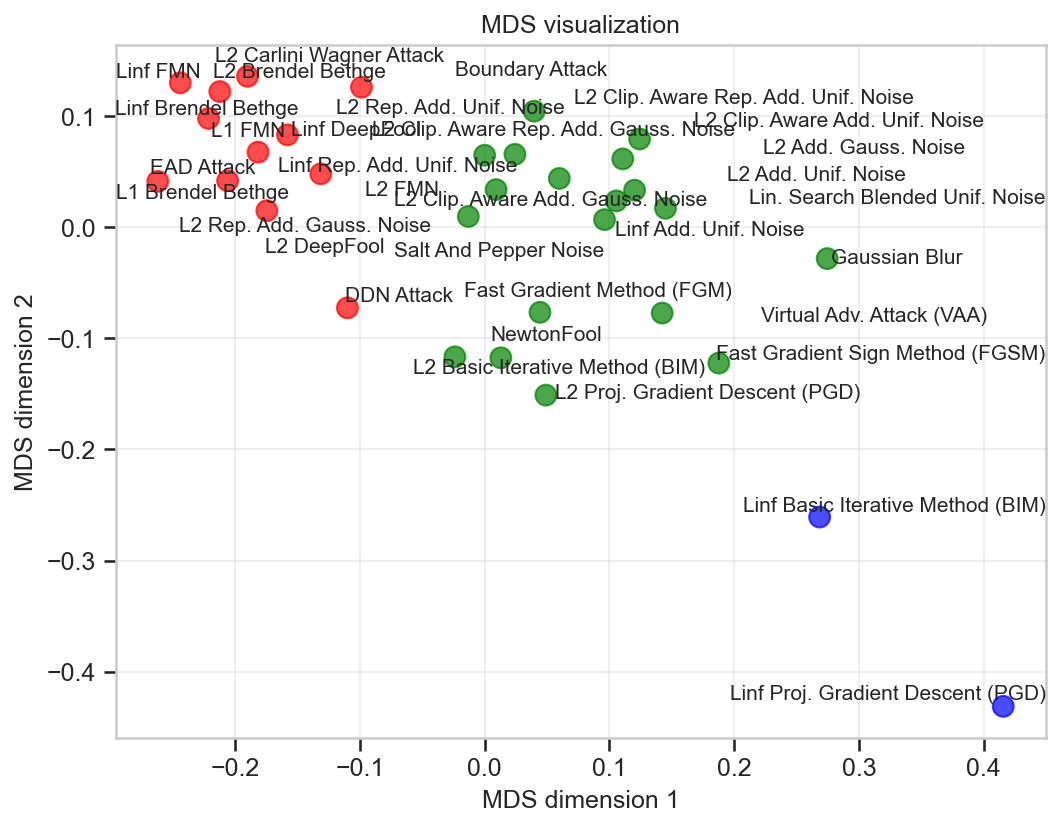


Clustering Summary for jensen_shannon_average:
  hierarchical: 3 clusters (silhouette: 0.473)  spectral: 3 clusters (silhouette: 0.482)

In [19]:
attack_analyzer = AdversarialAttacksAnalysis(attack_df)

attack_analyzer.comprehensive_analysis(['average'])

In [39]:
# add cluster information to dataframe

# map label to attack
attack_to_label = {attack: label for label, attack in zip(attack_analyzer.clustering_results["jensen_shannon_average"]["hierarchical"]["labels"], attack_analyzer.attacks)}
attack_df["cluster_attack"] = attack_df["attack"].map(attack_to_label)


--- Predicting cluster_attack ---
Accuracy: 0.744004469785966
              precision    recall  f1-score   support

           0       0.77      0.58      0.66     23292
           1       0.49      0.02      0.04      4228
           2       0.74      0.90      0.81     42282

    accuracy                           0.74     69802
   macro avg       0.66      0.50      0.50     69802
weighted avg       0.73      0.74      0.72     69802



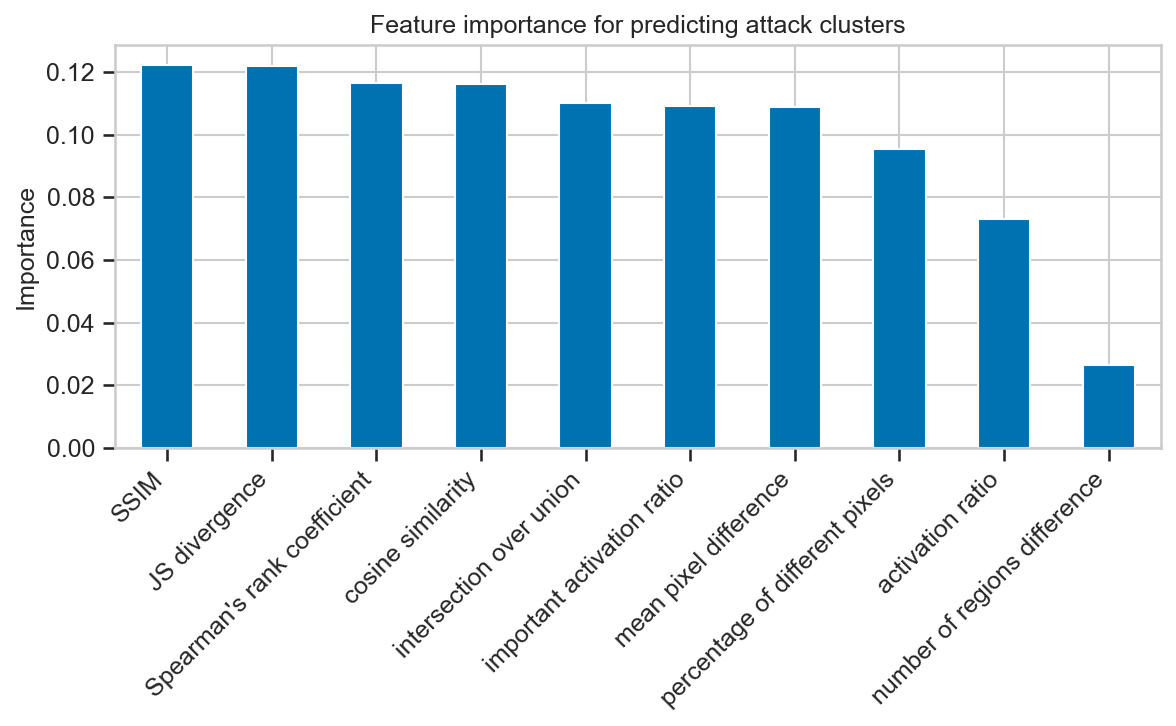

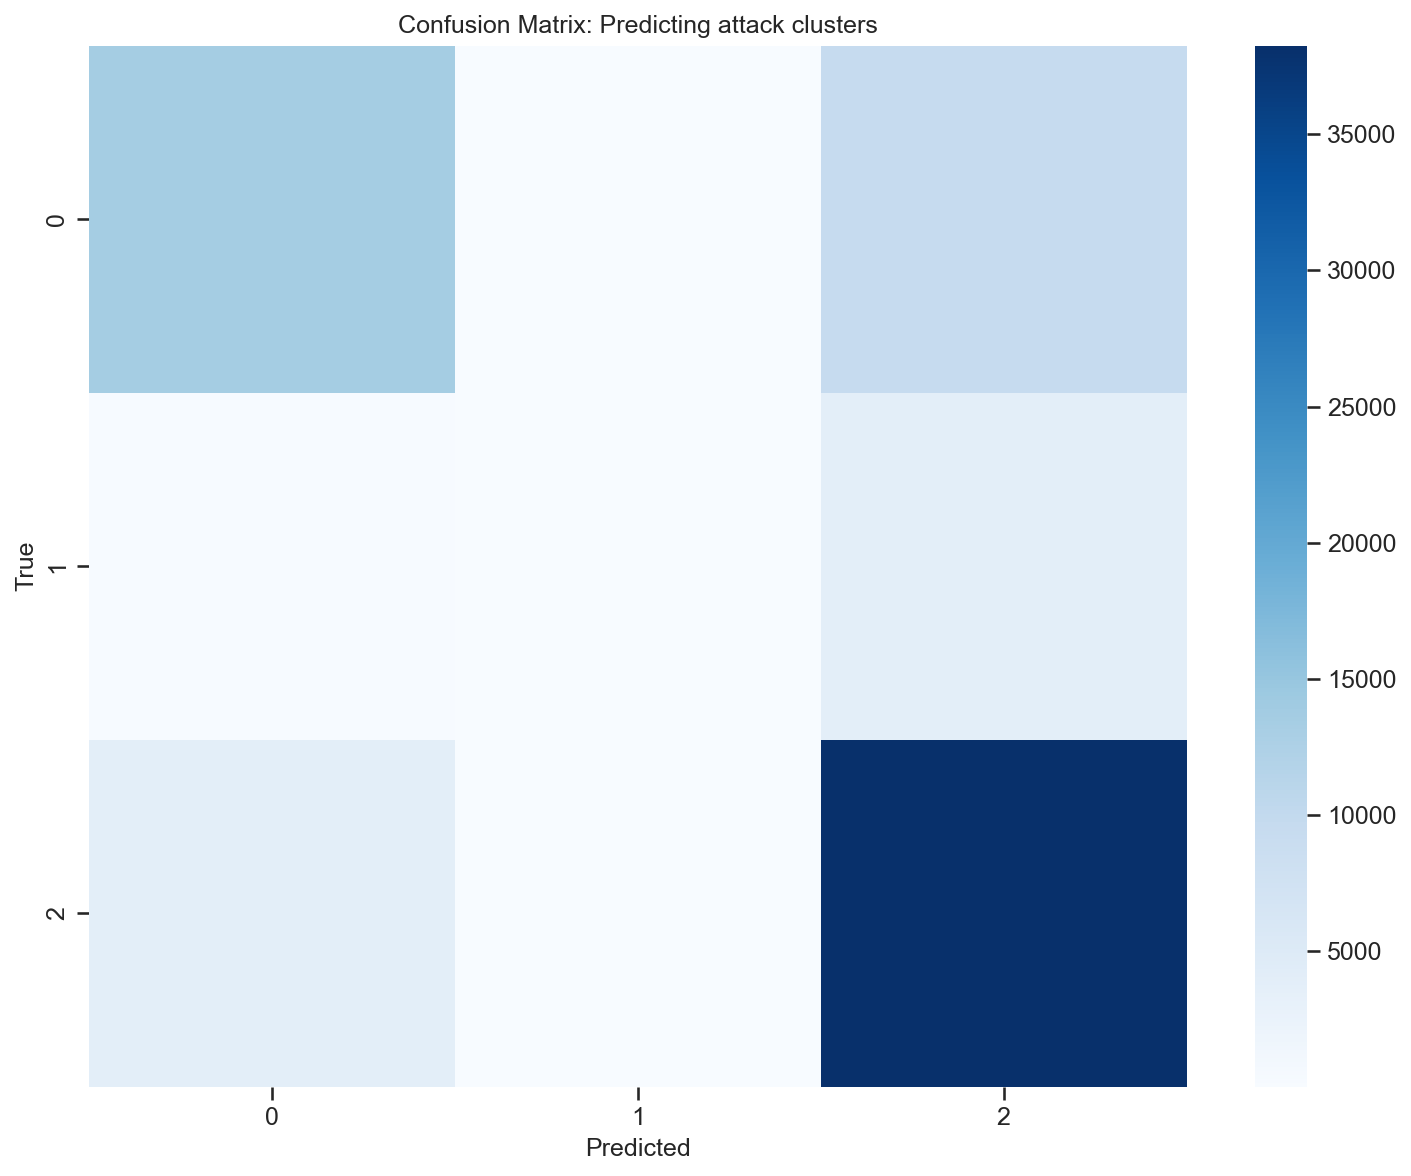

In [40]:
run_rf_classification(attack_df, "cluster_attack", "attack clusters", metric_columns, save_plot=True)


--- Predicting attack ---
Accuracy: 0.4993123406206126
              precision    recall  f1-score   support

           0       0.93      0.53      0.68      2114
           1       0.00      0.00      0.00      2114
           2       0.45      0.01      0.02      2114
           3       1.00      0.43      0.60      2115
           4       1.00      1.00      1.00      2114
           5       1.00      0.99      1.00      2114
           6       0.68      0.35      0.46      2151
           7       0.78      0.02      0.03      2114
           8       0.98      0.86      0.91      2114
           9       1.00      0.74      0.85      2114
          10       0.41      0.02      0.04      2114
          11       0.08      1.00      0.15      2114
          12       0.72      0.04      0.08      2114
          13       0.49      0.39      0.43      2114
          14       0.47      0.42      0.44      2114
          15       0.47      0.36      0.41      2114
          16       0.41  

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


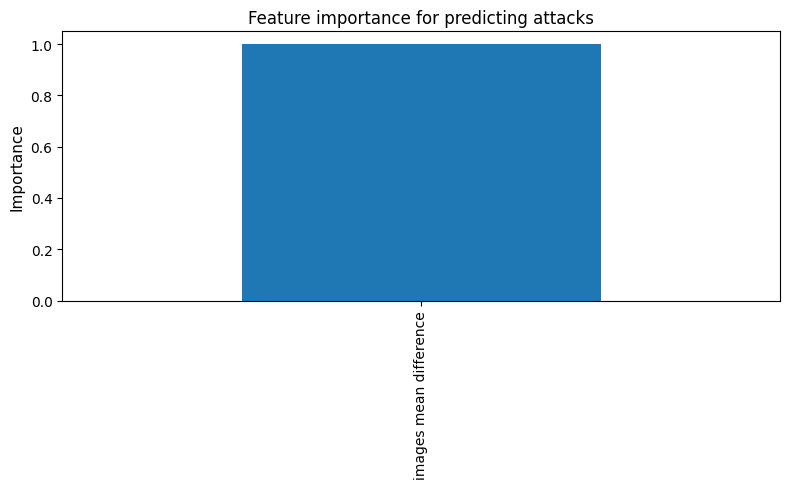

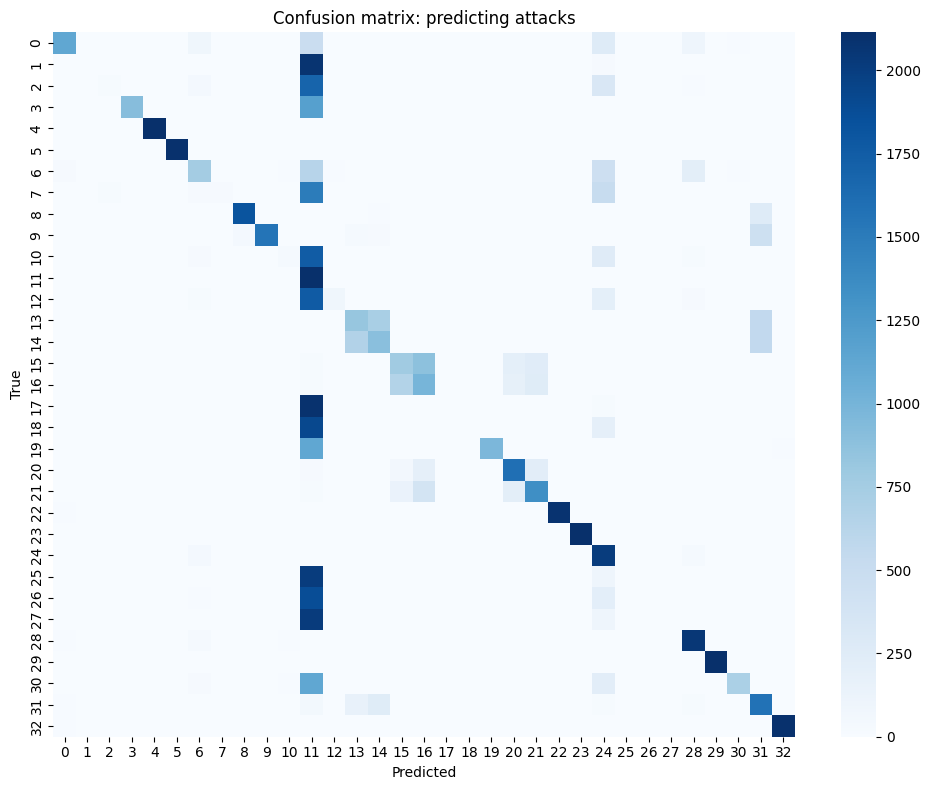

In [49]:
run_rf_classification(attack_df, "attack", "attacks", ["images mean difference"])


--- Predicting attack ---
Accuracy: 0.051975588092031746
              precision    recall  f1-score   support

           0       0.04      0.03      0.03      2114
           1       0.04      0.04      0.04      2114
           2       0.03      0.03      0.03      2114
           3       0.05      0.05      0.05      2115
           4       0.10      0.13      0.11      2114
           5       0.11      0.12      0.11      2114
           6       0.06      0.06      0.06      2151
           7       0.03      0.04      0.04      2114
           8       0.06      0.06      0.06      2114
           9       0.06      0.06      0.06      2114
          10       0.04      0.04      0.04      2114
          11       0.03      0.04      0.03      2114
          12       0.01      0.01      0.01      2114
          13       0.06      0.06      0.06      2114
          14       0.06      0.06      0.06      2114
          15       0.06      0.06      0.06      2114
          16       0.05

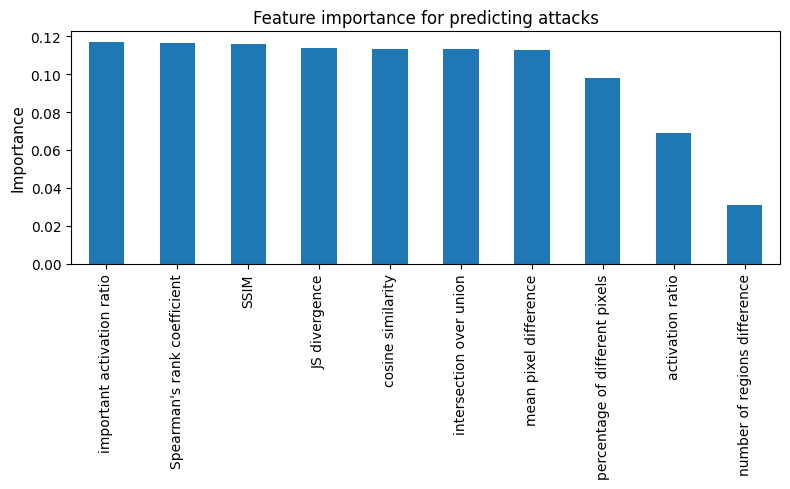

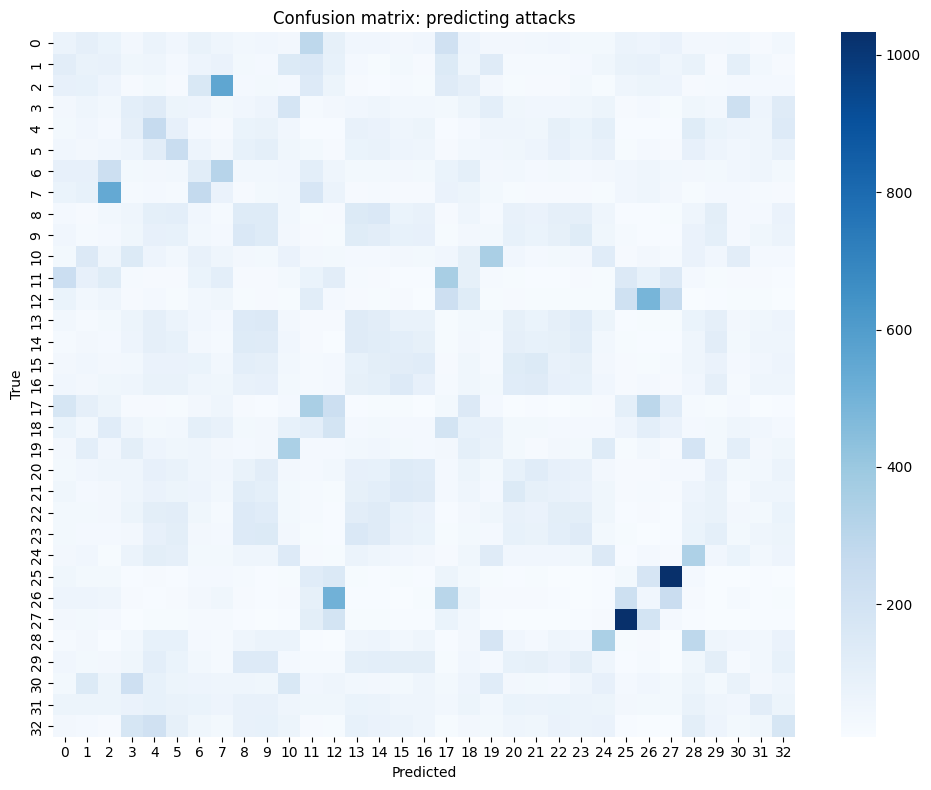

In [69]:
run_rf_classification(attack_df, "attack", "attacks", metric_columns)

# Method-attack interactions

In [8]:
# add integer column indicating the unique attack-method combinations
#results_df["method_attack"] = pd.factorize(results_df["attack"].astype(str) + "_" + results_df["method"].astype(str))[0]

attack_df["method_attack"] = attack_df["attack"].astype(str) + "_" + attack_df["method"].astype(str)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, silhouette_samples
from itertools import combinations
from scipy.special import kl_div
from adjustText import adjust_text
import matplotlib.colors as mcolors

class AttacksMethodsAnalysis:
    def __init__(self, results_df):
        """
        Initialize the analysis with your results dataframe
        """
        self.df = results_df
        self.metric_columns = [
            'mean pixel difference', 'activation ratio',
            'important activation ratio', 'JS divergence',    
            'number of regions difference'
        ] 


        self.attacks_methods = self.df['method_attack'].unique()
        self.distance_matrices_per_metric = {}
        self.combined_distance_matrices = {}
        self.clustering_results = {}
        self.silhouette_scores = {}


    def jensen_shannon_divergence(self, p, q, bins=20):
        """
        Calculate Jensen-Shannon divergence between two distributions
        """
        # Create histograms with same bins
        min_val = min(np.min(p), np.min(q))
        max_val = max(np.max(p), np.max(q))

        if min_val == max_val:
        # Both distributions are constant → they look identical
            return 0.0  
        bin_edges = np.linspace(min_val, max_val, bins + 1)
        
        hist_p, _ = np.histogram(p, bins=bin_edges, density=True)
        hist_q, _ = np.histogram(q, bins=bin_edges, density=True)
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10
        hist_p = hist_p + epsilon
        hist_q = hist_q + epsilon
        # Normalize to probabilities
        hist_p = hist_p / np.sum(hist_p)
        hist_q = hist_q / np.sum(hist_q)
        
        # Calculate M = (P + Q) / 2
        m = (hist_p + hist_q) / 2
        
        # KL divergence
        def kl_divergence(x, y):
            return np.sum(x * np.log(x / y))
        
        # JS divergence
        js_div = 0.5 * kl_divergence(hist_p, m) + 0.5 * kl_divergence(hist_q, m)
        return js_div
    
    def calculate_distance_matrices_per_metric(self):
        """
        Calculate distance matrices for each metric separately
        """
        n_attacks = len(self.attacks_methods)
        
        for metric in self.metric_columns:
            print(f"Calculating distances for {metric}...")
            
            # Initialize distance matrices
            js_matrix = np.zeros((n_attacks, n_attacks))

            # Get distributions for each attack
            attack_distributions = {}
            for method_attack in self.attacks_methods:
                attack_data = self.df[self.df['method_attack'] == method_attack][metric].dropna()
                if len(attack_data) == 0:
                    print(f"Warning: No data for method attack {method_attack} and metric {metric}")
                    continue
                attack_distributions[method_attack] = attack_data.values

            # Calculate pairwise distances
            for i, attack1 in enumerate(self.attacks_methods):
                for j, attack2 in enumerate(self.attacks_methods):
                    if i == j:
                        js_matrix[i, j] = 0
                  
                    else:
                        if attack1 in attack_distributions and attack2 in attack_distributions:
                            dist1 = attack_distributions[attack1]
                            dist2 = attack_distributions[attack2]

                            # Jensen-Shannon divergence
                            js_matrix[i, j] = self.jensen_shannon_divergence(dist1, dist2)

              
            self.distance_matrices_per_metric[metric] = {
                'jensen_shannon': js_matrix
            }
        print(np.isnan(js_matrix).sum(), "NaNs in js_matrix")
    
    def combine_distance_matrices(self, combination_method='average'):
        """
        Combine distance matrices across all metrics
        
        combination_method options:
        - 'average': Simple average of distances across metrics
        - 'weighted_average': Weighted by inverse of metric variance
        - 'max': Maximum distance across metrics
        - 'euclidean': Euclidean distance in metric space
        """
        n_attacks = len(self.attacks_methods)
        n_metrics = len(self.metric_columns)

        for distance_type in ['jensen_shannon']:
            if combination_method == 'average':
                # Simple average
                combined_matrix = np.zeros((n_attacks, n_attacks))
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        D = self.distance_matrices_per_metric[metric][distance_type]

                        # Compute robust min/max using percentiles
                        p_low, p_high = np.percentile(D, [0.05, 99.5])
                        print(p_low, p_high, "low and high percentiles")
                        if p_high == p_low:
                            D_norm = np.zeros_like(D)
                        else:
                            D_norm = np.clip((D - p_low) / (p_high - p_low), 0, 1)
                        #D_norm = np.clip((D - p_low) / (p_high - p_low), 0, 1)  # clip to [0,1]

                        combined_matrix += D_norm
                        #combined_matrix += self.distance_matrices_per_metric[metric][distance_type]
                combined_matrix /= len(self.metric_columns)
                
            elif combination_method == 'weighted_average':
                # Weighted by inverse variance of each metric
                weights = []
                matrices = []
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        matrix = self.distance_matrices_per_metric[metric][distance_type]
                        # Calculate weight as inverse of variance
                        variance = np.var(matrix[matrix > 0])
                        weight = 1.0 / (variance + 1e-10)  # Add small epsilon to avoid division by zero
                        weights.append(weight)
                        matrices.append(matrix)
                
                weights = np.array(weights)
                weights = weights / np.sum(weights)  # Normalize weights

                combined_matrix = np.zeros((n_attacks, n_attacks))
                for weight, matrix in zip(weights, matrices):
                    combined_matrix += weight * matrix
                    
            elif combination_method == 'max':
                # Maximum distance across metrics
                combined_matrix = np.zeros((n_attacks, n_attacks))
                for metric in self.metric_columns:
                    if metric in self.distance_matrices_per_metric:
                        matrix = self.distance_matrices_per_metric[metric][distance_type]
                        combined_matrix = np.maximum(combined_matrix, matrix)
                        
            elif combination_method == 'euclidean':
                # Euclidean distance in metric space
                combined_matrix = np.zeros((n_attacks, n_attacks))
                for i in range(n_attacks):
                    for j in range(n_attacks):
                        if i != j:
                            distances = []
                            for metric in self.metric_columns:
                                if metric in self.distance_matrices_per_metric:
                                    distances.append(self.distance_matrices_per_metric[metric][distance_type][i, j])
                            combined_matrix[i, j] = np.sqrt(np.sum(np.array(distances)**2))
            
            self.combined_distance_matrices[f"{distance_type}_{combination_method}"] = combined_matrix
            
        print(f"Combined distance matrices using {combination_method} method")
    
    def calculate_silhouette_scores(self, distance_matrix_key, max_clusters=33):
        """
        Calculate silhouette scores for different numbers of clusters
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        silhouette_scores = {}
        
        for n_clusters in range(2, min(len(self.attacks_methods), max_clusters + 1)):
            scores = {}
            
            # Hierarchical clustering
            linkage_matrix = linkage(squareform(distance_matrix), method='ward')
            hier_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
            if len(np.unique(hier_labels)) == n_clusters:  # Check if we got the expected number of clusters
                scores['hierarchical'] = silhouette_score(distance_matrix, hier_labels, metric='precomputed')
            
            # Spectral clustering
            try:
                sigma = np.median(distance_matrix[distance_matrix > 0])
                affinity_matrix = np.exp(-distance_matrix / (2 * sigma**2))
                np.fill_diagonal(affinity_matrix, 1)
                
                spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
                spec_labels = spectral.fit_predict(affinity_matrix)
                if len(np.unique(spec_labels)) == n_clusters:
                    scores['spectral'] = silhouette_score(distance_matrix, spec_labels, metric='precomputed')
            except Exception as e:
                print(f"Spectral clustering failed for {n_clusters} clusters: {e}")
            
            # Agglomerative clustering
            try:
                agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                                       metric='precomputed', 
                                                       linkage='average')
                agg_labels = agg_clustering.fit_predict(distance_matrix)
                if len(np.unique(agg_labels)) == n_clusters:
                    scores['agglomerative'] = silhouette_score(distance_matrix, agg_labels, metric='precomputed')
            except Exception as e:
                print(f"Agglomerative clustering failed for {n_clusters} clusters: {e}")
            
            silhouette_scores[n_clusters] = scores
        
        self.silhouette_scores[distance_matrix_key] = silhouette_scores
        return silhouette_scores
    
    
    def perform_clustering_with_optimal_clusters(self, distance_matrix_key, num_clusters=None):
        """
        Perform clustering using optimal number of clusters based on silhouette scores
        """
        if distance_matrix_key not in self.silhouette_scores:
            self.calculate_silhouette_scores(distance_matrix_key)
        
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        results = {}
        
        # Find optimal clusters for other methods
        silhouette_data = self.silhouette_scores[distance_matrix_key]
        
        for method in ['hierarchical', 'spectral', 'agglomerative']:
            method_scores = {k: v.get(method, -1) for k, v in silhouette_data.items()}
            if num_clusters is not None:
                optimal_clusters = num_clusters
            else:
                optimal_clusters = max(method_scores, key=method_scores.get)

            print(f"Optimal clusters for {method}: {optimal_clusters} (silhouette score: {method_scores[optimal_clusters]:.3f})")
            
            if method == 'hierarchical':
                linkage_matrix = linkage(squareform(distance_matrix), method='ward')
                labels = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')
                results[method] = {
                    'labels': labels,
                    'n_clusters': optimal_clusters,
                    'silhouette_score': method_scores[optimal_clusters],
                    'linkage_matrix': linkage_matrix
                }
            elif method == 'spectral':
                sigma = np.median(distance_matrix[distance_matrix > 0])
                affinity_matrix = np.exp(-distance_matrix / (2 * sigma**2))
                np.fill_diagonal(affinity_matrix, 1)
                
                spectral = SpectralClustering(n_clusters=optimal_clusters, affinity='precomputed', 
                                            random_state=42)
                labels = spectral.fit_predict(affinity_matrix) + 1
                results[method] = {
                    'labels': labels,
                    'n_clusters': optimal_clusters,
                    'silhouette_score': method_scores[optimal_clusters]
                }
        
        self.clustering_results[distance_matrix_key] = results
        return results
    
    def plot_silhouette_analysis(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot silhouette scores for different numbers of clusters
        """
        if distance_matrix_key not in self.silhouette_scores:
            self.calculate_silhouette_scores(distance_matrix_key)
        
        silhouette_data = self.silhouette_scores[distance_matrix_key]
        
        plt.figure(figsize=figsize)

        methods = ['hierarchical', 'spectral']
        colors = ['blue', 'red']
        markers = ['o', 's']

        # Plot both methods on the same plot
        for idx, method in enumerate(methods):
            clusters = []
            scores = []
            for n_clusters, method_scores in silhouette_data.items():
                if method in method_scores:
                    clusters.append(n_clusters)
                    scores.append(method_scores[method])
            
            if clusters:
                plt.plot(clusters, scores, marker=markers[idx], color=colors[idx], 
                        linewidth=2, markersize=8, label=f'{method.title()} Clustering')

        plt.title(f'Silhouette score comparison')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette score')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"latex/img/results/silhouette_analysis_{distance_matrix_key}_methods_attacks.svg")
        plt.show()
    
    def plot_combined_distance_heatmap(self, distance_matrix_key, figsize=(20, 15)):
        """
        Plot heatmap of combined distance matrix
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        
        plt.figure(figsize=figsize)
        sns.heatmap(distance_matrix, 
                   xticklabels=self.attacks_methods, yticklabels=self.attacks_methods,
                   annot=True, fmt='.2f', cmap='coolwarm')
        plt.title(f'Combined distance matrix')
        plt.tight_layout()
        plt.show()
    

    def visualize_cluster_grid(self, clustering_key, algorithm="hierarchical", figsize=(8, 10)):
        """
        Visualize the clustering results as a grid:
        - rows = attacks
        - columns = methods
        - each cell = cluster assignment (number + colour)
        """
        if clustering_key not in self.clustering_results:
            raise ValueError(f"No clustering results found for {clustering_key}")

        labels = self.clustering_results[clustering_key][algorithm]["labels"]

        # Get unique method_attack combos
        unique_combos = self.df["method_attack"].unique()
        if len(unique_combos) != len(labels):
            raise ValueError(
                f"Number of labels ({len(labels)}) does not match number of unique method_attack combos ({len(unique_combos)})"
            )

        # Build mapping DataFrame
        cluster_df = pd.DataFrame({
            "method_attack": unique_combos,
            "cluster": labels
        })
        cluster_df[["attack", "method"]] = cluster_df["method_attack"].str.split("_", n=1, expand=True)
        # Define desired order  
        attack_order = [
            "Linf Brendel Bethge", "L1 Brendel Bethge", "L2 Brendel Bethge", "L2 Carlini Wagner Attack", "EAD Attack", 
            "Linf FMN", "L1 FMN", "L2 FMN", "Boundary Attack", "Linf DeepFool", "L2 DeepFool", "DDN Attack", 
            "Fast Gradient Sign Method (FGSM)", "Fast Gradient Method (FGM)", "Virtual Adv. Attack (VAA)", "Gaussian Blur",
            "Linf Add. Unif. Noise", "Linf Rep. Add. Unif. Noise", "L2 Add. Unif. Noise", "L2 Rep. Add. Unif. Noise", 
            "L2 Clip. Aware Add. Unif. Noise", "L2 Clip. Aware Rep. Add. Unif. Noise", 
            "L2 Add. Gauss. Noise", "L2 Rep. Add. Gauss. Noise", "L2 Clip. Aware Rep. Add. Gauss. Noise", 
            "L2 Clip. Aware Add. Gauss. Noise", "Salt And Pepper Noise", 
            "Lin. Search Blended Unif. Noise",  "NewtonFool",
            "Linf Basic Iterative Method (BIM)", "L2 Basic Iterative Method (BIM)",  "Linf Proj. Gradient Descent (PGD)", "L2 Proj. Gradient Descent (PGD)",
        ]

        method_order = [
            "GradCAM", "AblationCAM", "ScoreCAM", "GradCAM++", "LayerCAM", 
            "EigenCAM", "KPCA-CAM", "EigenGradCAM", "FullGrad"]

        # Convert columns to ordered categoricals
        cluster_df["attack"] = pd.Categorical(cluster_df["attack"], categories=attack_order, ordered=True)
        cluster_df["method"] = pd.Categorical(cluster_df["method"], categories=method_order, ordered=True)
        # Pivot: attacks x methods
        pivot = cluster_df.pivot(index='attack', columns='method', values='cluster')

        # Determine number of clusters present in your pivot
        n_clusters = cluster_df["cluster"].nunique()

        # Use the same colormap (Accent) with discrete bins
        cmap = plt.colormaps["Accent"].resampled(n_clusters)
        cmap = mcolors.ListedColormap([cmap(i) for i in range(n_clusters)])

        # Plot
        plt.figure(figsize=figsize)
        ax = sns.heatmap(
            pivot,
            annot=True, fmt="d",
            cmap=cmap,
            cbar=False,        # no continuous bar (clusters are categorical)
            linewidths=0.5,
            linecolor="lightgrey"
        )
        ax.set_title("Cluster assignments per attack/method")
        ax.set_xlabel("Method")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_ylabel("Attack")
        plt.tight_layout()
        plt.savefig(f"latex/img/results/clustering_methods_attacks.svg")
        plt.show()


    def plot_dendrogram(self, distance_matrix_key, figsize=(8, 6)):
        """
        Plot dendrogram for hierarchical clustering
        """
        if distance_matrix_key not in self.clustering_results:
            self.perform_clustering_with_optimal_clusters(distance_matrix_key)
        
        plt.figure(figsize=figsize)
        linkage_matrix = self.clustering_results[distance_matrix_key]['hierarchical']['linkage_matrix']
        
        dendrogram(linkage_matrix, labels=self.attacks_methods, leaf_rotation=90, leaf_font_size=10)
        plt.title(f'Hierarchical Clustering Dendrogram')
        plt.ylabel('Distance')
        plt.xlabel('Method')
        plt.tight_layout()
        plt.show()
    
    def mds_visualization(self, distance_matrix_key, figsize=(8, 6)):
        """
        Visualize methods using MDS based on combined distance matrix
        """
        distance_matrix = self.combined_distance_matrices[distance_matrix_key]
        
        # Perform MDS
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        coords = mds.fit_transform(distance_matrix)
        
        # Use spectral clustering results
        if distance_matrix_key in self.clustering_results:
            labels = self.clustering_results[distance_matrix_key]['spectral']['labels']
        else:
            labels = np.zeros(coords.shape[0], dtype=int)  # fallback if no clustering

        n_clusters = len(np.unique(labels))
        cmap = plt.colormaps["Accent"].resampled(n_clusters)
        plt.figure(figsize=figsize)
        scatter = plt.scatter(
            coords[:, 0],
            coords[:, 1],
            s=100,
            alpha=0.7,
            c=labels,          # cluster IDs directly
            cmap=cmap
        )

        plt.title(f'MDS visualization')
        plt.xlabel('MDS dimension 1')
        plt.ylabel('MDS dimension 2')
        plt.grid(True, alpha=0.3)

        plt.savefig(f"latex/img/results/mds_methods_attacks.svg")
        plt.show()
    
    def comprehensive_analysis(self, combination_methods=['average', 'weighted_average']):
        """
        Run comprehensive analysis with all combination methods
        """
        print("=== COMPREHENSIVE ADVERSARIAL ATTACK ANALYSIS ===\n")
        
        # Calculate distance matrices per metric
        self.calculate_distance_matrices_per_metric()
        
        # Try different combination methods
        for comb_method in combination_methods:
            print(f"\n{'='*60}")
            print(f"ANALYSIS WITH {comb_method.upper()} COMBINATION METHOD")
            print('='*60)
            
            # Combine matrices
            self.combine_distance_matrices(comb_method)
            
            # Analyze both distance types
            for distance_type in ['jensen_shannon']:
                matrix_key = f"{distance_type}_{comb_method}"
                
                print(f"\n--- {distance_type.title()} Distance ---")
                
                
                # Calculate silhouette scores
                self.calculate_silhouette_scores(matrix_key)
                
                # Plot silhouette analysis
                self.plot_silhouette_analysis(matrix_key)
                
                # Perform clustering with optimal number of clusters
                results = self.perform_clustering_with_optimal_clusters(matrix_key)
                

                self.mds_visualization(matrix_key)
                self.visualize_cluster_grid(matrix_key)
                # Print summary
                print(f"\nClustering Summary for {matrix_key}:")
                for method, result in results.items():
                    print(f"  {method}: {result['n_clusters']} clusters", end="")
                    if 'silhouette_score' in result:
                        print(f" (silhouette: {result['silhouette_score']:.3f})", end="")

    def summary_report(self):
        """
        Generate a summary report
        """
        print("=== ADVERSARIAL ATTACK ANALYSIS SUMMARY ===\n")
        print(f"Dataset shape: {self.df.shape}")
        print(f"Number of attacks_methods: {len(self.attacks_methods)}")
        print(f"Attacks: {', '.join(self.attacks_methods)}")
        print(f"Number of images: {len(self.df['image ID'].unique())}")
        print(f"Metrics analyzed: {len(self.metric_columns)}")
        
        print("\n=== BASIC STATISTICS ===")
        for metric in self.metric_columns:
            print(f"\n{metric}:")
            stats_df = self.df.groupby('method')[metric].agg(['count', 'mean', 'std', 'median']).round(4)
            print(stats_df)

=== COMPREHENSIVE ADVERSARIAL ATTACK ANALYSIS ===

Calculating distances for mean pixel difference...
Calculating distances for activation ratio...
Calculating distances for important activation ratio...
Calculating distances for JS divergence...
Calculating distances for number of regions difference...
0 NaNs in js_matrix

ANALYSIS WITH AVERAGE COMBINATION METHOD
0.0 0.46299946335426123 low and high percentiles
0.0 0.40777401825292864 low and high percentiles
0.0 0.15611440536818963 low and high percentiles
0.0 0.39741216450840694 low and high percentiles
0.0 0.23412750021776926 low and high percentiles
Combined distance matrices using average method

--- Jensen_Shannon Distance ---


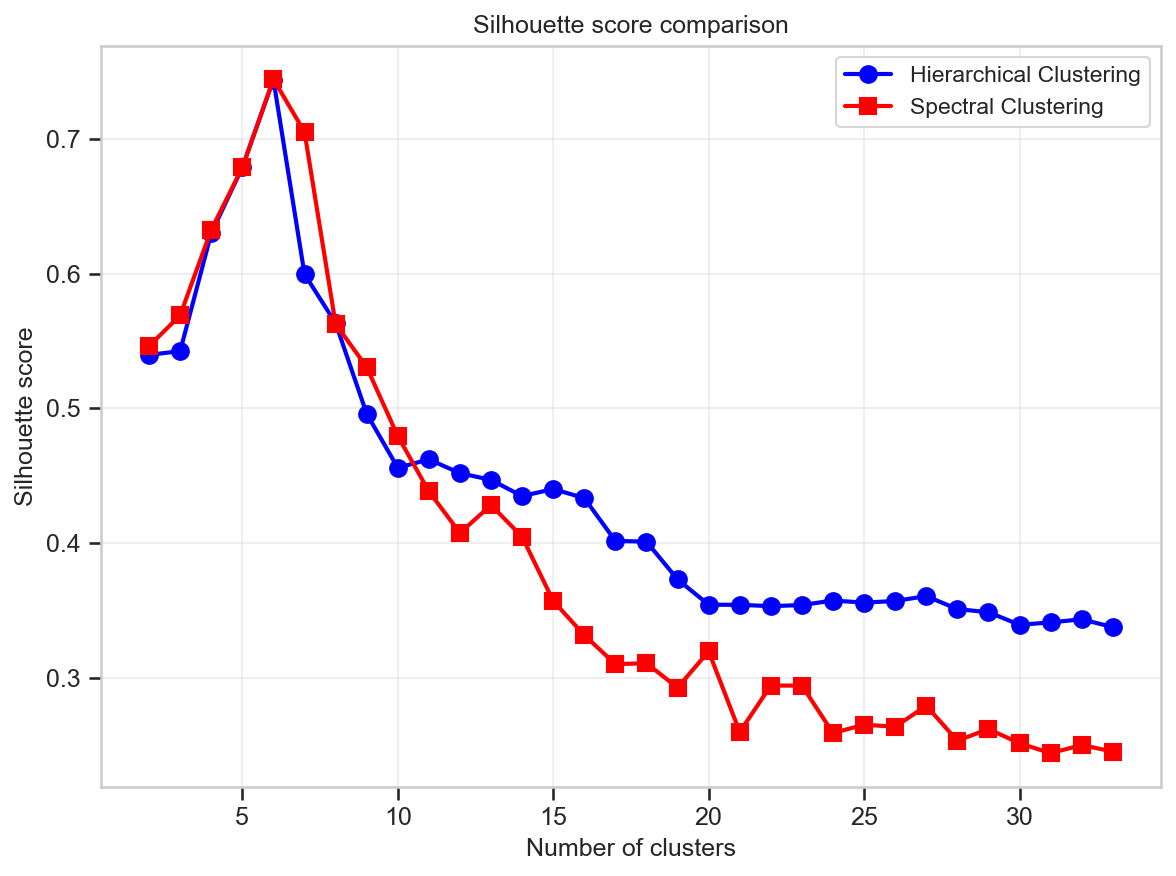

Optimal clusters for hierarchical: 6 (silhouette score: 0.744)
Optimal clusters for spectral: 6 (silhouette score: 0.744)
Optimal clusters for agglomerative: 6 (silhouette score: 0.744)


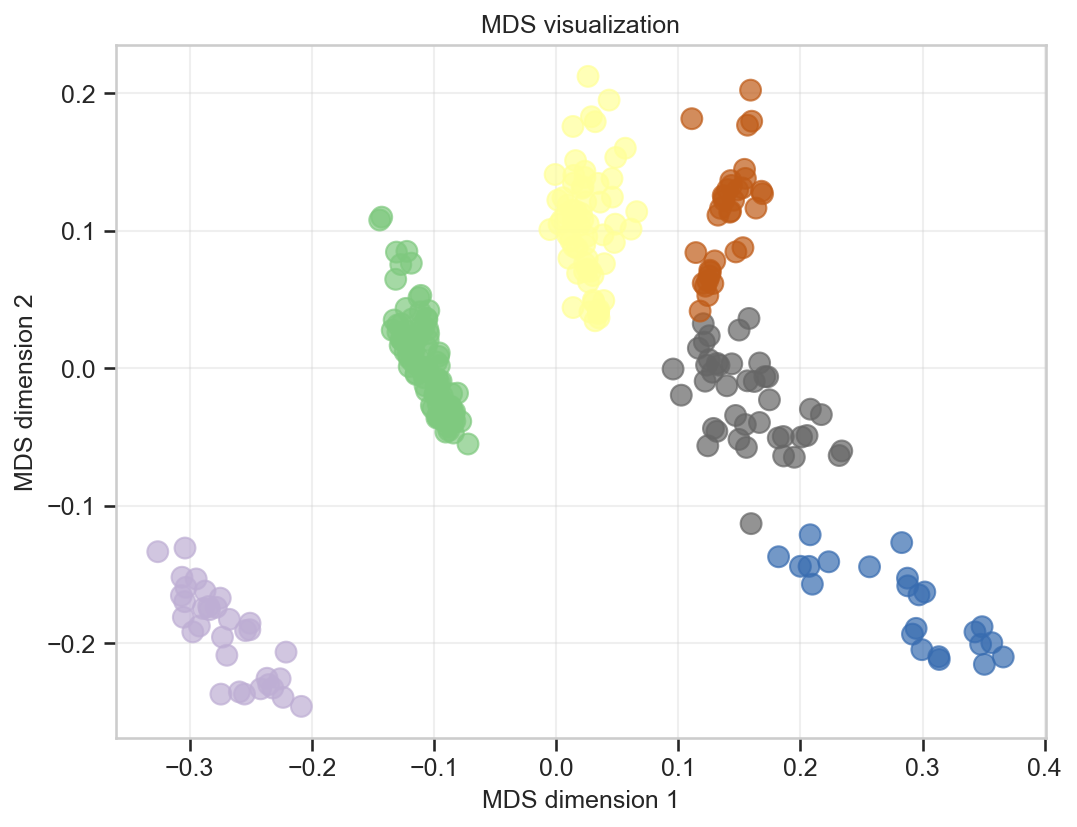

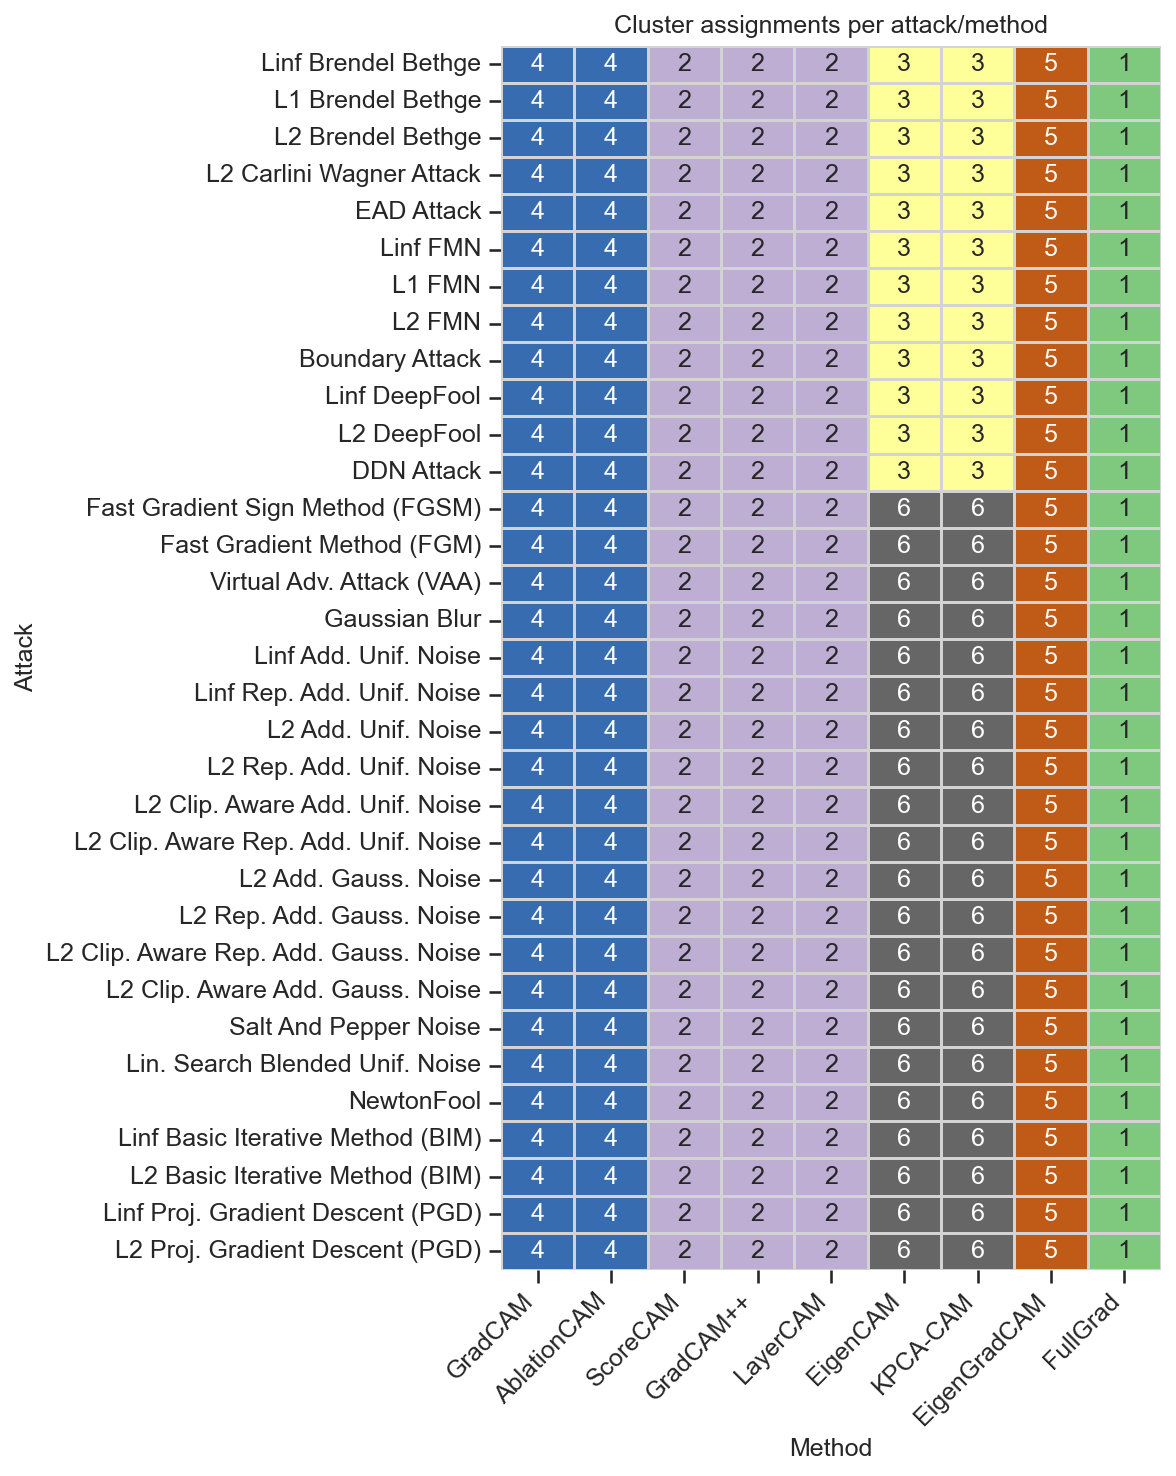


Clustering Summary for jensen_shannon_average:
  hierarchical: 6 clusters (silhouette: 0.744)  spectral: 6 clusters (silhouette: 0.744)

In [10]:
method_attack_analyzer = AttacksMethodsAnalysis(attack_df)
method_attack_analyzer.comprehensive_analysis(['average'])


--- Predicting method_attack ---
Accuracy: 0.012633333333333333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       106
           1       0.03      0.02      0.02       100
           2       0.00      0.00      0.00        96
           3       0.02      0.02      0.02       101
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00       100
           6       0.01      0.01      0.01        99
           7       0.01      0.01      0.01        99
           8       0.00      0.00      0.00       109
           9       0.00      0.00      0.00       110
          10       0.00      0.00      0.00       101
          11       0.02      0.02      0.02        99
          12       0.02      0.02      0.02       106
          13       0.01      0.01      0.01       108
          14       0.01      0.01      0.01        99
          15       0.03      0.04      0.04       106
          16    

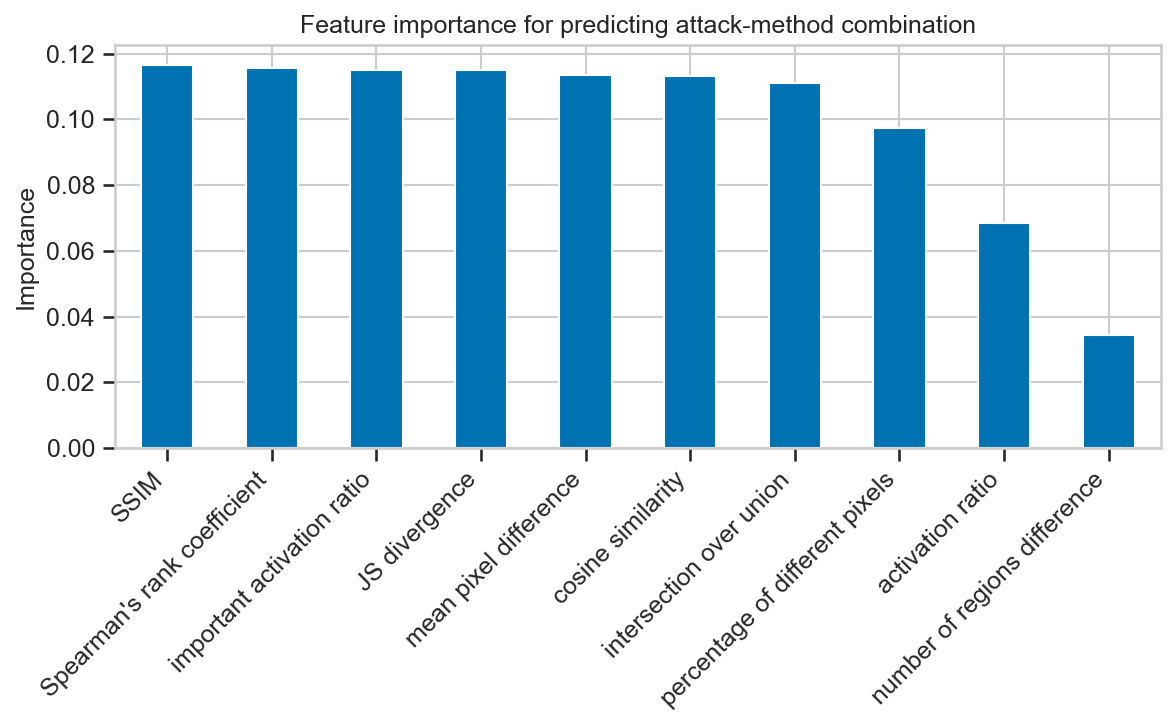

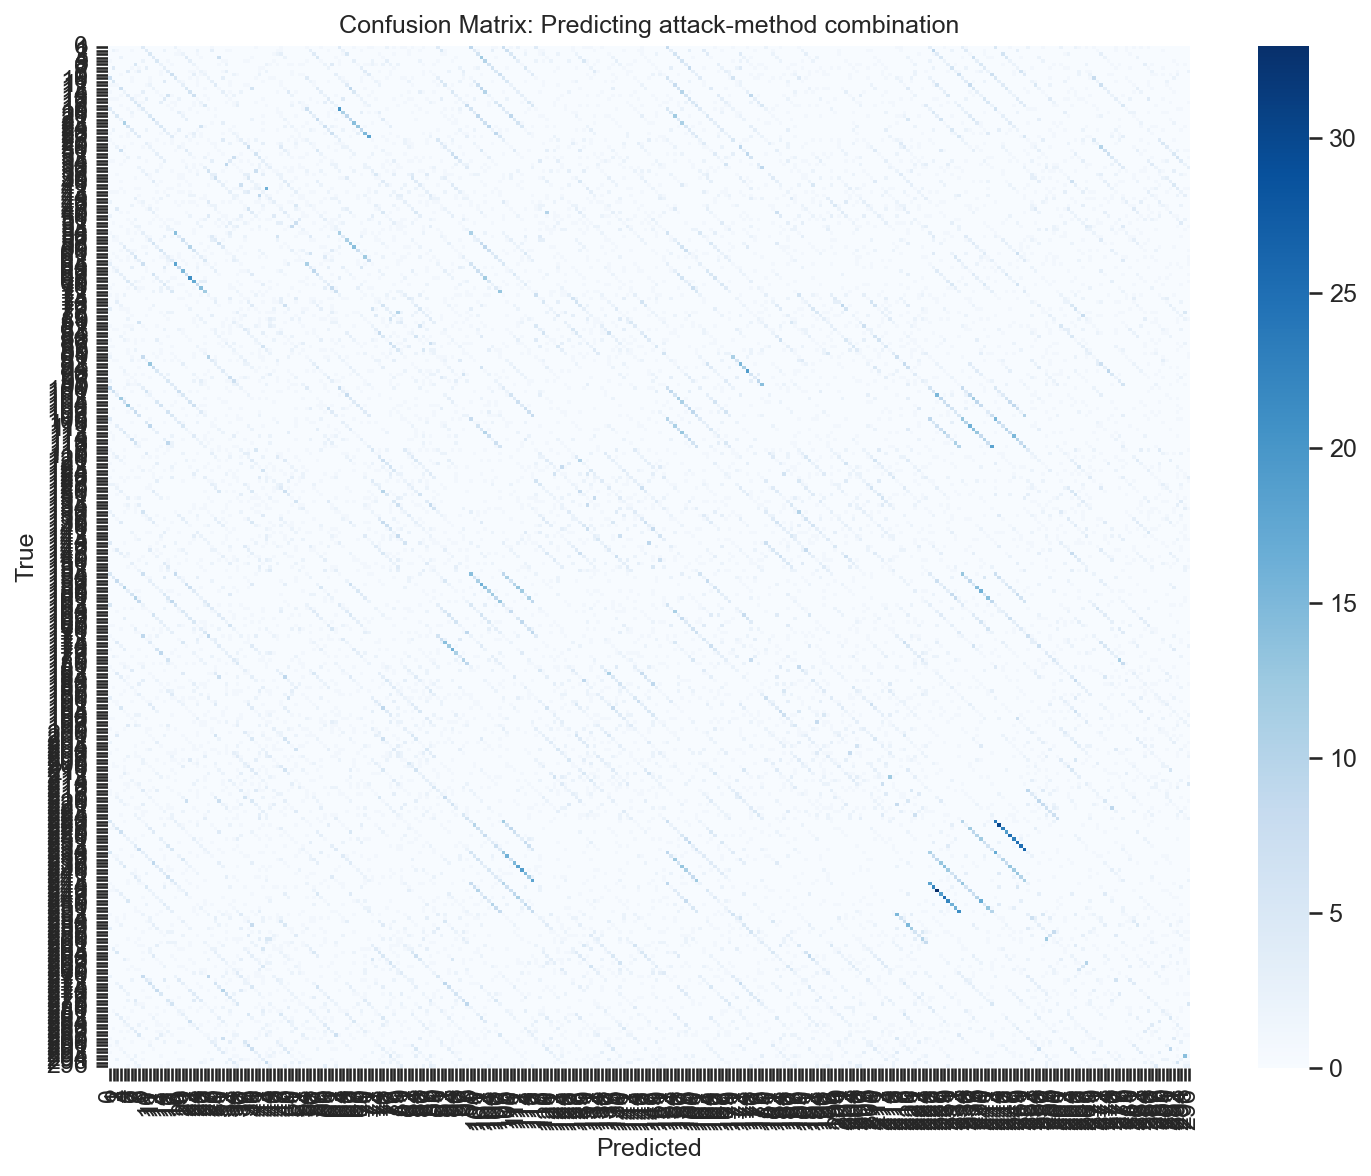

In [14]:
# randomly subsample before doing rf classifier

sampled_df = attack_df.sample(n=100000, random_state=2)
run_rf_classification(sampled_df, "method_attack", "attack-method combination", metric_columns)

# RF on clustering results

In [15]:
attack_method_to_label = {method_attack: label for label, method_attack in zip(method_attack_analyzer.clustering_results["jensen_shannon_average"]["hierarchical"]["labels"], 
                                                                 method_attack_analyzer.attacks_methods)}

attack_df["cluster_attack_method"] = attack_df["method_attack"].map(attack_method_to_label)


--- Predicting cluster_attack_method ---
Accuracy: 0.8327698346752243
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      7756
           1       0.89      0.95      0.92     23268
           2       0.71      0.63      0.67      5645
           3       0.90      0.86      0.88     15511
           4       0.75      0.75      0.75      7756
           5       0.66      0.66      0.66      9866

    accuracy                           0.83     69802
   macro avg       0.80      0.79      0.79     69802
weighted avg       0.83      0.83      0.83     69802



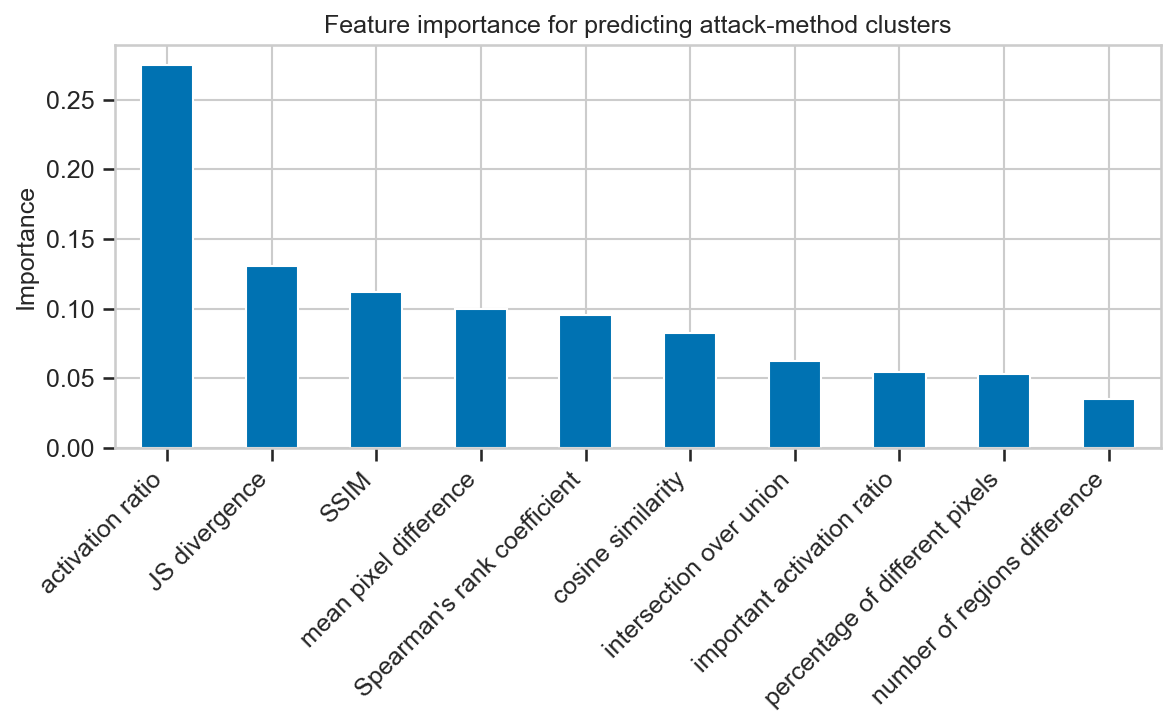

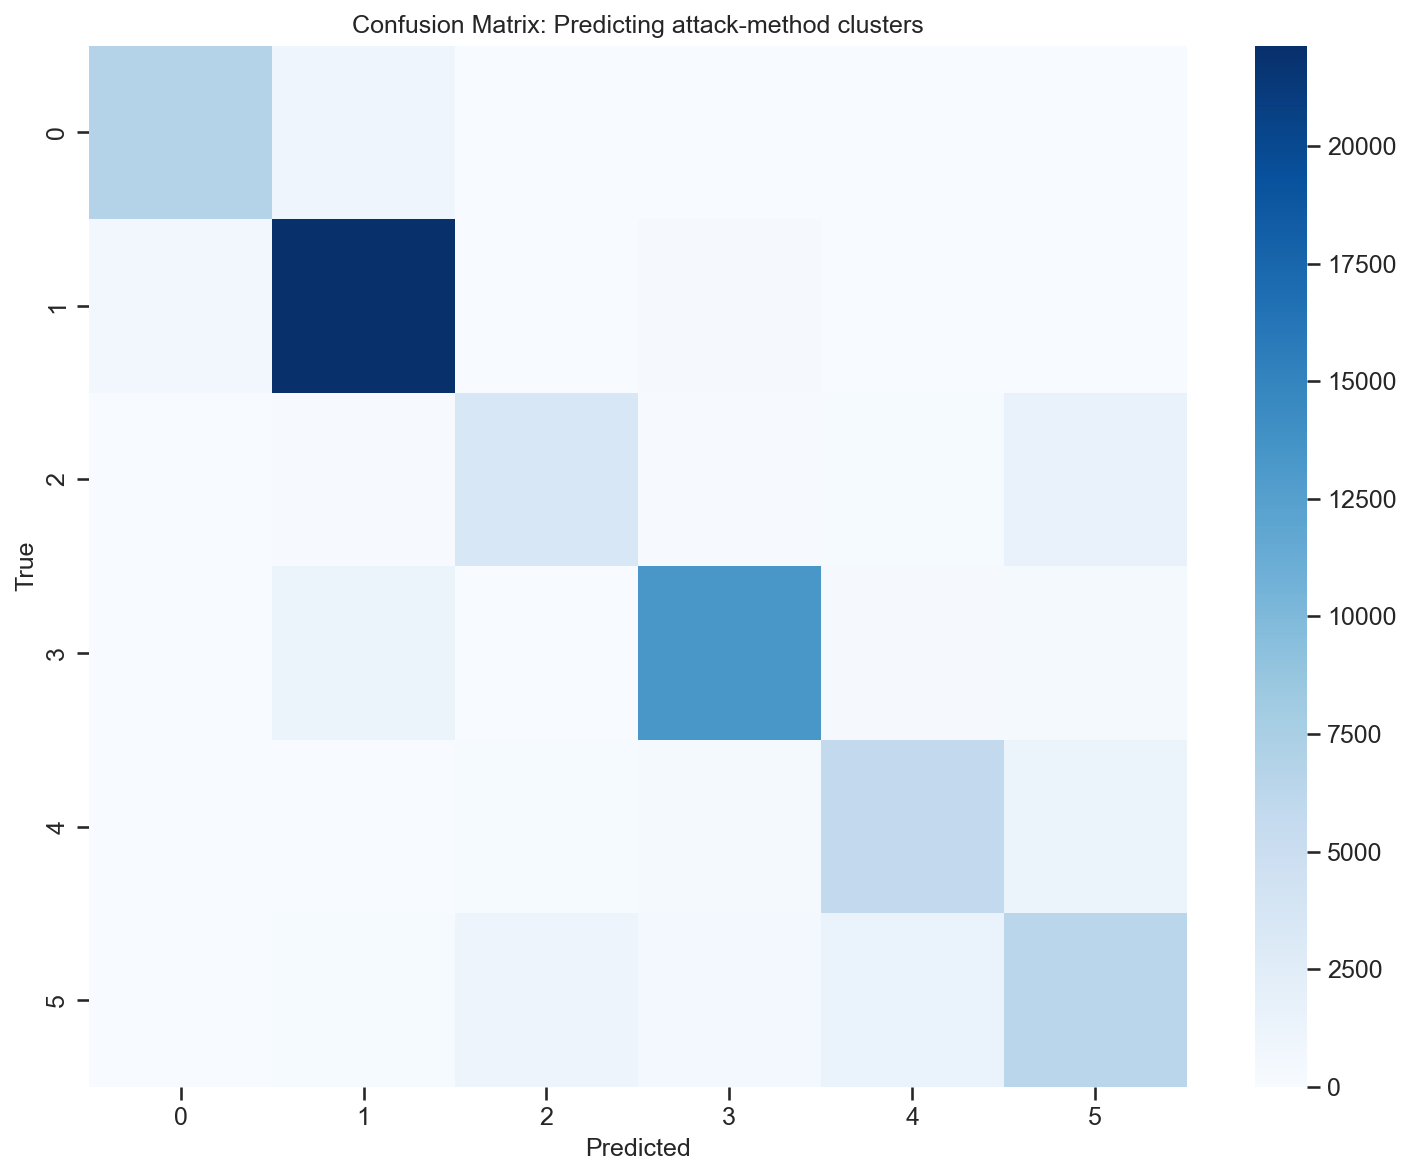

In [16]:
run_rf_classification(attack_df, "cluster_attack_method", "attack-method clusters", metric_columns)